# Notebook for Computing and Visualizing the Lineage Probability Distributions

###### Lineage-specific intolerance to oncogenic drivers restricts histological transformation

###### https://www.biorxiv.org/content/10.1101/2023.06.21.545980v1

## Import Jobs

In [12]:
import pandas as pd
import numpy as np
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as hc
import matplotlib.patches as patches
import plotly.express as px

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

import matplotlib as mpl
import matplotlib
from matplotlib import rcParams
from adjustText import adjust_text
from scipy.stats import zscore
from copy import deepcopy
from kneed.knee_locator import KneeLocator
from sklearn.metrics.cluster import adjusted_rand_score
from py_pcha.PCHA import PCHA
from skimage import filters
from scipy import stats

import palantir
import scipy
import sys
import os
import glob
import anndata
import itertools
import phenograph
import sklearn
import scanorama
import scikit_posthocs
import time

from os import path
from pathlib import Path
from scipy.ndimage.filters import convolve

In [13]:
# Define output directory:
output_dir = '/workdir/varmus_single_cell/merged_pipeline_out/Lineage_Prob_Visuals_pubShare/'

!mkdir -p {output_dir}
print(f'output_dir: {output_dir}')
run_in_background_wait_default=True

output_dir: /workdir/varmus_single_cell/merged_pipeline_out/Lineage_Prob_Visuals_pubShare/


In [1]:
# Style of notebook in browser (optional)

boolean_to_color = {True:'crimson',False:'steelblue'}

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))
display(HTML("<style>.output_result { max-width:85% !important; }</style>"))

In [15]:
# Define figure formatting parameters

%matplotlib inline

sc.settings.figdir = output_dir
sc.set_figure_params(dpi=80, dpi_save=300)

matplotlib.style.use('default')

sns.set_style('white')

plt.rcParams['figure.figsize']=(6,4) #rescale figures
sc.settings.verbosity = 4

In [16]:
# Helper functions:

def filter_genes(adata, minCell):
    hasCell = adata.layers['X'] > 0
    numCell = np.array(hasCell.sum(axis=0))
    tooSmall = [i < minCell for i in numCell]
    is_invalid = np.zeros(adata.shape[1], np.bool)
    is_invalid[np.where(tooSmall)[0]] = True
    print(f"Removing {np.sum(is_invalid)} out of {len(is_invalid)} genes with less than {minCell} cells")
    adata.var['n_cells_by_counts'] = numCell
    return is_invalid

def flatten(l):
    if all(isinstance(x, list) for x in l):
        return [item for sublist in l for item in sublist]
    elif all(isinstance(x, np.ndarray) for x in l):
        return [item for sublist in l for item in sublist]
    else:
        return l
    
def read_mast_results(xls, sheetname, filter_genes=None, filter_label='_filtered', reverse=False,
                      sortBy='scaled_rank_score'):
    print("Reading " + sheetname)
    mastResults = pd.read_excel(xls, sheetname)
    mastResults.rename(index=str, columns={"primerid": "gene", "coef": "log2FC", 'Pr(>Chisq)':'p',
                                          'Pr..Chisq.':'p'}, inplace=True, errors='ignore')
    pmin= np.min(np.array([x for x in mastResults.p if x!=0]))
    fdrmin = np.min(np.array([x for x in mastResults.fdr if x!=0]))
    #mastResults.log2FC[np.isnan(mastResults.log2FC)] = np.nanmax(mastResults.log2FC)
    mastResults = mastResults[(np.isnan(mastResults['ci.lo']) == False) & (np.isnan(mastResults['ci.hi']) == False)]
    mastResults.drop(['Unnamed: 0'], axis=1, inplace=True)
    mastResults.set_index('gene', drop=True, inplace=True)
    mastResults['bonferroni'] = mastResults['p']*mastResults.shape[0]
    bonmin = np.min(np.array([x for x in mastResults.bonferroni if x!=0]))
    mastResults.loc[mastResults.p==0,'p'] = pmin
    mastResults.loc[mastResults.fdr==0,'fdr'] = fdrmin
    mastResults.loc[mastResults.bonferroni==0,'bonferroni'] = bonmin
    mastResults.loc[mastResults.bonferroni > 1,'bonferroni'] = 1
    mastResults['rank_score'] = -10*np.log10(mastResults['bonferroni'])*np.sign(mastResults['log2FC'])
    mastResults['FC'] = 2.0**mastResults['log2FC']
    mastResults['scaled_rank_score'] = mastResults['rank_score']*np.abs(mastResults['log2FC'])
    mastResults['abs_scaled_rank_score'] = np.abs(mastResults['scaled_rank_score'])
    if reverse:
        mastResults['log2FC'] = -mastResults['log2FC']
        mastResults['FC'] = 1.0/mastResults['FC']
        mastResults['ci.hi'] = -mastResults['ci.hi']
        mastResults['ci.lo'] = -mastResults['ci.lo']
        mastResults['rank_score'] = -mastResults['rank_score']
        mastResults['scaled_rank_score'] = -mastResults['scaled_rank_score']
    mastResults = mastResults.sort_values(by=sortBy, ascending=False)
    if filter_genes is not None:
        mastResults = mastResults.loc[[g for g in mastResults.index if g in filter_genes]]
        filename=os.path.splitext(sheetname)[0] + filter_label + '.csv'
        mastResults[['p', 'log2FC', 'FC', 'fdr', 'ci.hi','ci.lo','bonferroni','rank_score', 'scaled_rank_score']].to_csv(filename)
    return(mastResults)

In [17]:
# Import mouse to human mapping dictionary from GitHub:

import pickle 

with open('/workdir/varmus_single_cell/code/github_notebooks/mToH_mapping.pkl', 'rb') as f:
    mToH_mapping = pickle.load(f)

## Define Value Maps

In [ ]:
cell_type_cmap = {'Tumor cells': '#A4D10A', 
                  'AT1': '#E37979', 
                  'AT2': '#C70B0B', 
                  'LUAD': '#A3523B',
                  'B cells': '#F9D318', 
                  'Basal cells': '#7FD5A6', 
                  'Chondrocytes': '#79A274',
                  'Club cells': '#D36C39', 
                  'Transitional Club-AT2': '#C64A18',
                  'EC arterial': '#6B0C0C', 
                  'EC aerocyte': '#8D6868',
                  'EC general capillary': '#BF5B5B', 
                  'EC venous': '#782C2C', 
                  'Lymphatic EC': '#BD872F',
                  'Ciliated cells': '#D39939', 
                  'cDC1': '#C438FB',
                  'cDC2': '#E9B1FF',
                  'Migratory DCs': '#962A6F',
                  'DCs': '#C438FB',
                  'Endothelial cells': '#6B0C0C',
                  'Stromal cells': '#9BA65A', 
                  'Ionocyte': '#3C787D',
                  'Tuft': '#66966C',
                  'Secretory cells': '#B0A170',
                  'Submucosal cells': '#A4B070',
                  'Pericytes': '#046C50',
                  'Myofibroblasts': '#C15376',
                  'Smooth muscle': '#946E6E',
                  'Mesothelium': '#E16666',
                  'Fibroblast cells': '#216C04', 
                  'Alveolar macrophages': '#7AD9DA',
                  'Interstitial Macrophages': '#7AAEDA',
                  'Macrophages/mMDSC': '#7AC0DA',
                  'Monocytes': '#51ECAE', 
                  'Monocytic cells': '#51ECAE',
                  'Mast cells': '#A16E0F', 
                  'Multiciliated cells': '#F17C62',
                  'NK cells': '#EA0C0C', 
                  'Granulocytic cells': '#9CA7A8', 
                  'T cells': '#F47D08', 
                  'Plasma cells': '#90F162',
                  'Mature B cells/Plasma cells': '#90F162',
                  'pDC': '#51119A',
                  'PNEC': '#0B11C7',
                  'Tumor AT2': '#A3523B',
                  'Tumor PNEC': '#3B3587',
                  'Tumor cells': '#8A7B7B',
                  'unassigned': '#DEDEDE'}

cell_type_name_map = {'Tumor cells': 'Tumor cells', 
                      'AT1': 'AT1', 
                      'AT2': 'AT2', 
                      'B cells': 'B cells', 
                      'Basal Cells': 'Basal cells', 
                      'Chondrocyte': 'Chondrocytes',
                      'Club cell': 'Club cells', 
                      'Transitional Club AT2': 'Transitional Club-AT2',
                      'EC arterial': 'EC arterial', 
                      'EC aerocyte capillary': 'EC aerocyte',
                      'EC general capillary': 'EC general capillary', 
                      'EC venous': 'EC venous', 
                      'Lymphatic EC': 'Lymphatic EC',
                      'Ciliated cell': 'Ciliated cells', 
                      'DC1': 'cDC1',
                      'DC2': 'cDC2',
                      'Migratory DCs': 'Migratory DCs',
                      'DCs': 'DCs',
                      'Endothelial cell': 'Endothelial cells',
                      'Stromal Cell': 'Stromal cells', 
                      'Ionocyte': 'Ionocyte',
                      'Tuft': 'Tuft',
                      'Secretory Cells': 'Secretory cells',
                      'Submucosal': 'Submucosal cells',
                      'Pericytes': 'Pericytes',
                      'Myofibroblasts': 'Myofibroblasts',
                      'Smooth muscle': 'Smooth muscle',
                      'Mesothelium': 'Mesothelium',
                      'Fibroblasts': 'Fibroblast cells', 
                      'Alveolar macrophages': 'Alveolar macrophages',
                      'Interstitial Macrophages': 'Interstitial Macrophages',
                      'Macrophage': 'Macrophages/mMDSC',
                      'Macrophages': 'Macrophages/mMDSC',
                      'Monocytes': 'Monocytes', 
                      'Mast cells': 'Mast cells', 
                      'Multiciliated Cells': 'Multiciliated cells',
                      'NK cells': 'NK cells', 
                      'Granulocytic': 'Granulocytic cells', 
                      'T cells': 'T cells', 
                      'Plasma cells': 'Plasma cells',
                      'pDCs': 'pDC',
                      'PNEC': 'PNEC',
                      'unassigned': 'unassigned'}

## Import Data

### Full single cell atlas

In [65]:
# Define path to h5ad data from GEO:
data_dir = '/workdir/varmus_single_cell/data/NOBACKUP/GEO_Upload_1023/'

adata = sc.read(f'/{data_dir}/Gardner_et-al-2023_processed_adata_TEC_merged_new_samples.h5ad')

In [66]:
adata

AnnData object with n_obs × n_vars = 81395 × 23314
    obs: 'mt_frac', 'totReads', 'doublet_score', 'library_size', 'sample', 'origin', 'log_library_size', 'cellAssign_results', 'Macro Cell Type', 'project_batch'
    var: 'gene_ids', 'n_cells_by_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Macro Cell Type_colors', 'Project_colors', 'cellAssign_results_colors', 'draw_graph', 'hvg', 'pca', 'sample_colors', 'umap'
    obsm: 'DC', 'X_OG_draw_graph_fa', 'X_draw_graph_fa', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'X', 'X_impute', 'logX'

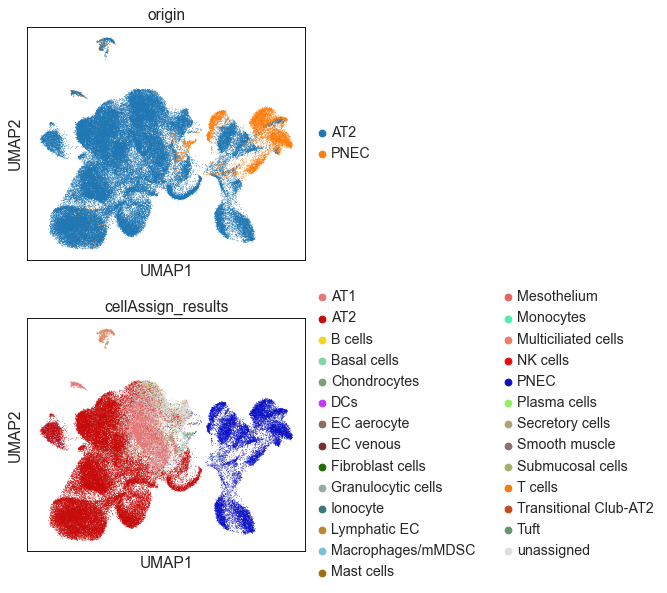

In [67]:
# Basic visual of data

sc.settings.verbosity = 4
sc.set_figure_params(dpi=80, dpi_save=300) 

adata.uns['origin_colors'] = ['#A3523B', '#0B11C7']

sc.pl.umap(adata, color=['origin', 'cellAssign_results'], s=2, ncols=1)

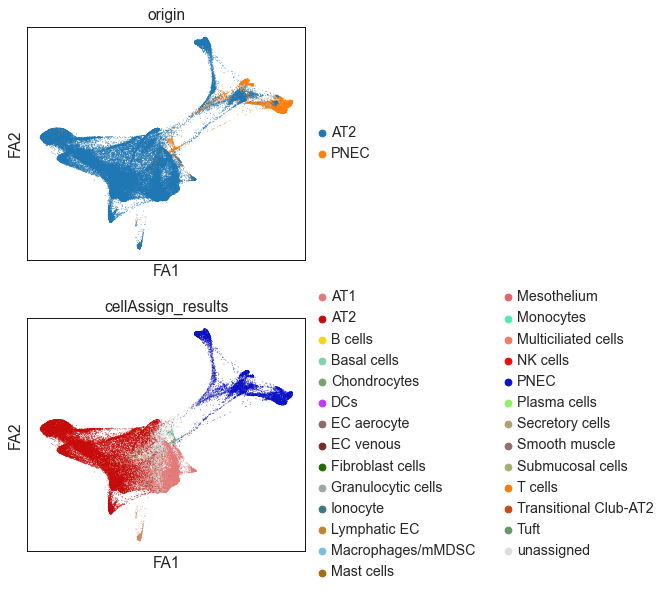

In [68]:
# Basic visual of data

sc.settings.verbosity = 4
sc.set_figure_params(dpi=80, dpi_save=300) 

sc.pl.draw_graph(adata, color=['origin', 'cellAssign_results'], s=2, ncols=1)

### Additional 3 Pten sample TEC subset

In [69]:
# Define path to h5ad data from GEO:
data_dir = '/workdir/varmus_single_cell/data/NOBACKUP/GEO_Upload_1023/'

adata_NEW = sc.read(f'/{data_dir}/Gardner_et-al-2023_processed_adata_additional_Pten_samples.h5ad')

In [70]:
adata_NEW

AnnData object with n_obs × n_vars = 15484 × 19265
    obs: 'mt_frac', 'totReads', 'doublet_score', 'sample', 'origin', 'project_batch', 'library_size', 'log_library_size', 'pheno_40', 'cellAssign_results'
    var: 'gene_ids', 'n_cells_by_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'cellAssign_results_colors', 'draw_graph', 'hvg', 'neighbors_40', 'pca', 'pheno_40_colors', 'sample_colors', 'umap'
    obsm: 'X_TEC_MERGED_draw_graph_fa', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'X', 'logX'
    obsp: 'neighbors_40_connectivities', 'neighbors_40_distances'

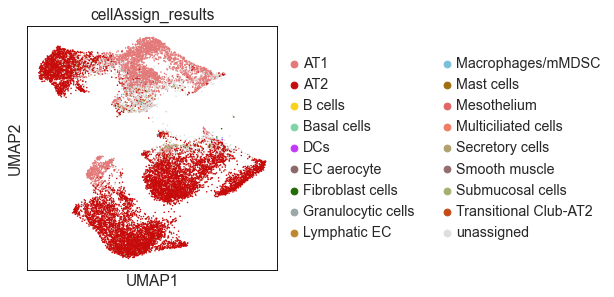

In [71]:
sc.settings.verbosity = 4
sc.set_figure_params(dpi=80, dpi_save=300) 

sc.pl.umap(adata_NEW, color='cellAssign_results')

In [72]:
# Remove multiciliated cells:

# First, since adata_NEW already has multiciliated removed, remove cells not in this adata from relevant samples:

f = list(set(adata[np.array(adata.obs['sample'].map(lambda x: x in adata_NEW.obs['sample'].unique())).astype(bool)].obs.index) - 
         set(adata_NEW.obs.index))

print(f'Removing {len(f)} multiciliated cells')

f = list(set(adata.obs.index) - set(f))

adata = adata[f,:]

# Filter:
f = len(adata[adata.obs['Macro Cell Type'] == 'Multiciliated cells'].obs)
print(f'Removing {f} multiciliated cells')

adata = adata[adata.obs['Macro Cell Type'] != 'Multiciliated cells']

# Remove genes no longer present:
adata.X = adata.layers['X']

print(adata.shape)
invalid_gene = filter_genes(adata, 1)
adata = adata[:,~invalid_gene]
adata.shape

Removing 63 multiciliated cells
Removing 474 multiciliated cells
(80858, 23314)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  # Remove the CWD from sys.path while we load stuff.


Removing 6 out of 23314 genes with less than 1 cells


/usr/lib/python3.7/contextlib.py:119: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  next(self.gen)


(80858, 23308)

In [73]:
# No longer need adata_NEW, clear from memory:

del adata_NEW

### Import cellAssign Probabilities

In [74]:
# Import cellAssign TEC probability results from data directory 
# files available in the LUAD_SCLC_HT repository on the Laughney GitHub

data_dir = '/workdir/varmus_single_cell/data/'

probs = pd.read_csv(f'/{data_dir}/full_adata_TEC_cellAssign_probs.csv', index_col=0)

In [75]:
# Match index format to merged data:

probs.index = probs.index.map(lambda x: x+'-0')

In [76]:
probs.head()

,AT1,AT2,Basal.Cells,Chondrocyte,Multiciliated.Cells,Transitional.Club.AT2,Ionocyte,Tuft,Secretory.Cells,Submucosal,PNEC
AAAGAACCAGAGCCCT-1-0-0,4.555497e-17,2.016386e-17,3.775186e-18,2.390898e-23,3.684157e-19,4.351543e-28,2.205823e-27,2.053282e-35,3.774204e-19,2.601072e-33,1.0
AAAGGATCAGGAACCA-1-0-0,5.419609e-51,1.169792e-46,2.225925e-52,1.045169e-51,1.496032e-59,5.100665e-58,4.488240e-54,1.415394e-68,1.370711e-53,6.259605e-70,1.0
AAAGGGCCAGCGTTTA-1-0-0,8.776911e-26,8.375672e-27,5.821195e-29,3.875412e-41,6.992294e-29,2.686530e-28,1.021436e-39,1.003870e-46,1.690232e-29,3.989081e-29,1.0
AAAGGTACACAGTATC-1-0-0,1.641449e-144,2.353128e-146,8.180129e-146,3.783952e-146,9.875761e-154,1.397793e-152,3.732559e-147,3.912374e-165,5.105510e-146,1.348658e-164,1.0
AAAGGTATCAGAGTGG-1-0-0,2.749077e-17,8.642719e-17,1.486165e-18,3.676714e-24,8.632744e-26,2.529843e-36,1.063031e-30,1.007831e-17,1.307632e-19,9.266024e-38,1.0


In [77]:
data_dir = '/workdir/varmus_single_cell/data/'

probs_new = pd.read_csv(f'/{data_dir}/New_Pten_Samples_TEC_cellAssign_probs.csv', index_col=0)

In [78]:
probs_new.head()

,AT1,AT2,Basal.Cells,Chondrocyte,Multiciliated.Cells,Transitional.Club.AT2,Ionocyte,Tuft,Secretory.Cells,Submucosal,PNEC
AAACCCAAGTTGCTCA-1-0-1,8.581423e-15,1.000000e+00,8.631870e-16,5.272583e-22,3.803312e-24,3.295389e-16,1.079536e-25,2.848914e-23,6.736336e-17,3.191598e-15,2.333728e-16
AAACCCACAATCGCAT-1-0-1,8.951571e-03,8.553990e-01,2.340953e-03,1.667607e-09,3.245945e-05,1.782182e-04,1.138973e-14,3.305821e-14,4.632397e-06,2.270798e-22,1.234121e-03
AAACCCACAATCGCGC-1-0-1,5.910922e-26,1.377108e-15,6.631525e-44,6.633035e-39,1.450230e-28,6.131648e-27,2.618336e-37,4.512395e-28,9.999743e-01,2.573381e-05,4.247338e-27
AAACCCACACTGATTG-1-0-1,4.711452e-50,1.000000e+00,3.558426e-52,1.504706e-70,8.844486e-66,5.325290e-52,1.811699e-70,2.748247e-73,9.930621e-50,7.840832e-59,9.584077e-52
AAACCCAGTTCCGCTT-1-0-1,1.887661e-95,1.000000e+00,2.643505e-99,6.199572e-106,4.866357e-101,6.778595e-99,1.151500e-99,9.737147e-119,1.548464e-100,3.769318e-101,5.783783e-99


In [79]:
# Merged cellAssign probs:

probs_merged = pd.concat([probs, probs_new])

In [80]:
probs_merged.head()

,AT1,AT2,Basal.Cells,Chondrocyte,Multiciliated.Cells,Transitional.Club.AT2,Ionocyte,Tuft,Secretory.Cells,Submucosal,PNEC
AAAGAACCAGAGCCCT-1-0-0,4.555497e-17,2.016386e-17,3.775186e-18,2.390898e-23,3.684157e-19,4.351543e-28,2.205823e-27,2.053282e-35,3.774204e-19,2.601072e-33,1.0
AAAGGATCAGGAACCA-1-0-0,5.419609e-51,1.169792e-46,2.225925e-52,1.045169e-51,1.496032e-59,5.100665e-58,4.488240e-54,1.415394e-68,1.370711e-53,6.259605e-70,1.0
AAAGGGCCAGCGTTTA-1-0-0,8.776911e-26,8.375672e-27,5.821195e-29,3.875412e-41,6.992294e-29,2.686530e-28,1.021436e-39,1.003870e-46,1.690232e-29,3.989081e-29,1.0
AAAGGTACACAGTATC-1-0-0,1.641449e-144,2.353128e-146,8.180129e-146,3.783952e-146,9.875761e-154,1.397793e-152,3.732559e-147,3.912374e-165,5.105510e-146,1.348658e-164,1.0
AAAGGTATCAGAGTGG-1-0-0,2.749077e-17,8.642719e-17,1.486165e-18,3.676714e-24,8.632744e-26,2.529843e-36,1.063031e-30,1.007831e-17,1.307632e-19,9.266024e-38,1.0


In [81]:
# Add probs to adata

probs_merged = probs_merged.loc[adata.obs.index]

for c in probs:
    
    c_mapped = cell_type_name_map[c.replace('.', ' ')]
    
    adata.obs[f'{c_mapped}_probs'] = probs_merged[c]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  if __name__ == '__main__':


In [82]:
adata

AnnData object with n_obs × n_vars = 80858 × 23308
    obs: 'mt_frac', 'totReads', 'doublet_score', 'library_size', 'sample', 'origin', 'log_library_size', 'cellAssign_results', 'Macro Cell Type', 'project_batch', 'AT1_probs', 'AT2_probs', 'Basal cells_probs', 'Chondrocytes_probs', 'Multiciliated cells_probs', 'Transitional Club-AT2_probs', 'Ionocyte_probs', 'Tuft_probs', 'Secretory cells_probs', 'Submucosal cells_probs', 'PNEC_probs'
    var: 'gene_ids', 'n_cells_by_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Macro Cell Type_colors', 'Project_colors', 'cellAssign_results_colors', 'draw_graph', 'hvg', 'pca', 'sample_colors', 'umap', 'origin_colors'
    obsm: 'DC', 'X_OG_draw_graph_fa', 'X_draw_graph_fa', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'X', 'X_impute', 'logX'

## FDLs

In [83]:
TEC_cellType_list = ['AT1', 'AT2', 'Basal cells', 'PNEC', 'Secretory cells',
                     'Submucosal cells', 'Transitional Club-AT2']

lineages_list = [x+'_probs' for x in TEC_cellType_list]

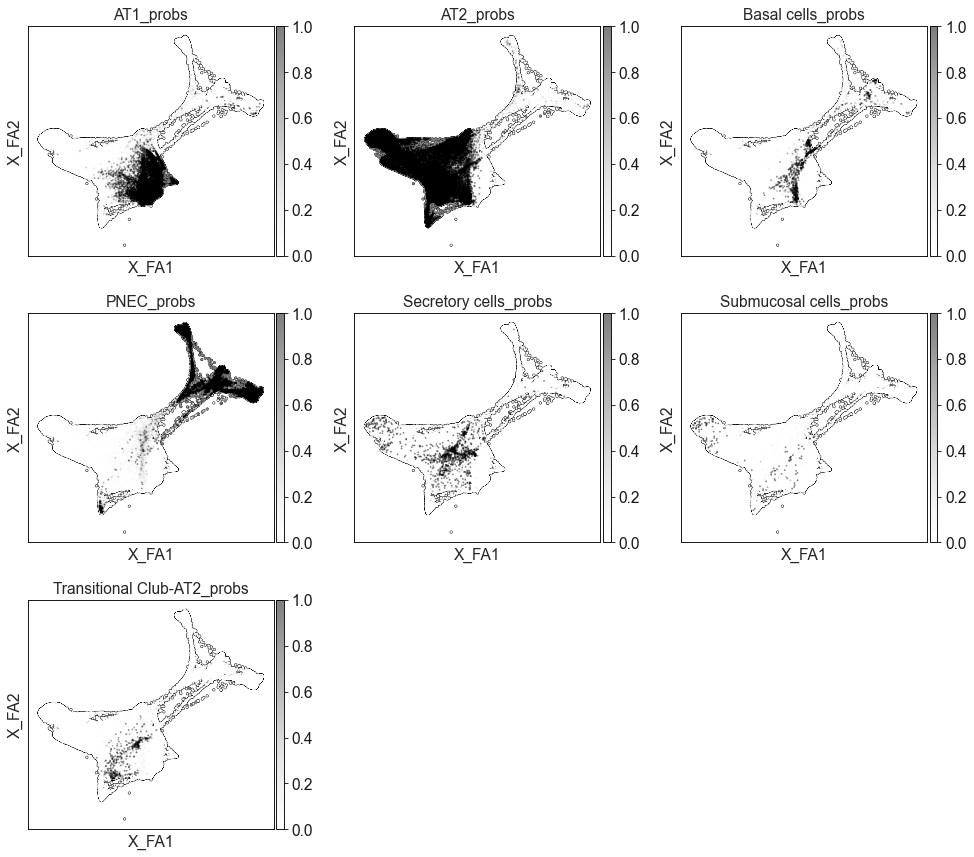

In [84]:
# Visualize on merged FDL:

sc.settings.verbosity = 4
sc.set_figure_params(dpi=80, dpi_save=300) 

sc.pl.embedding(adata,
                basis='X_draw_graph_fa',
                color=lineages_list,
                ncols=3,
                cmap='Greys',
                vmin=0,
                vmax=1,
                alpha=0.5,
                s=10,
                add_outline=True,
                save='_original_probs_FDLs.png')

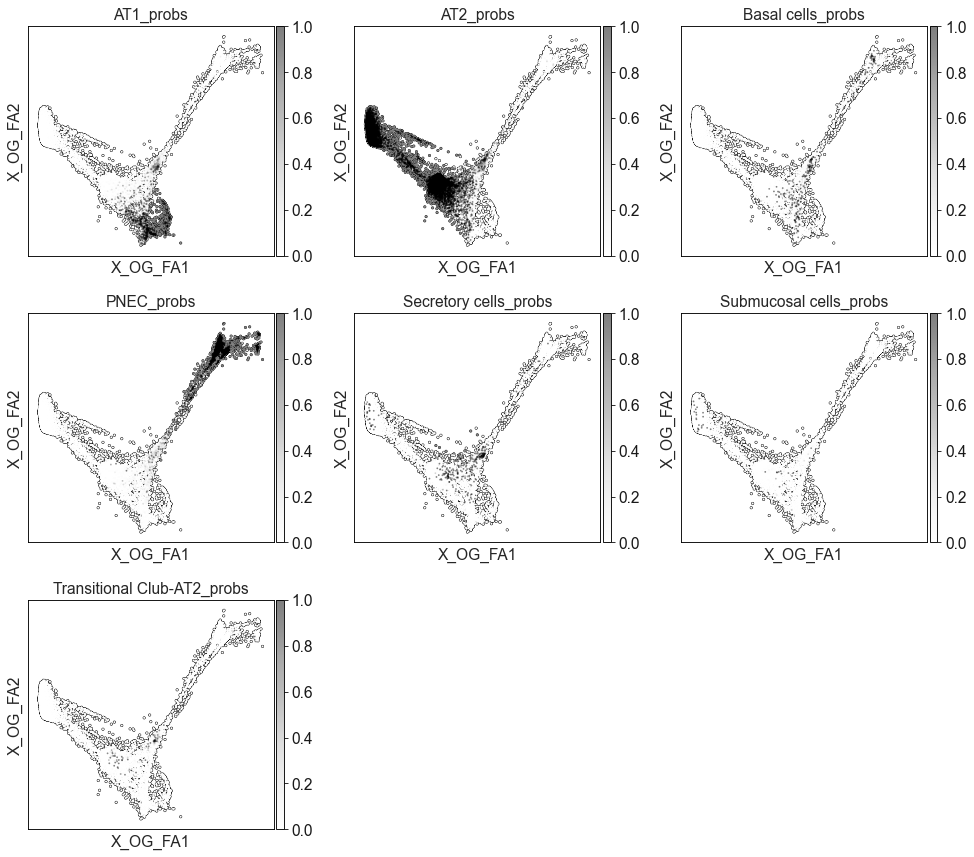

In [85]:
# Visualize on original FDL, subset to HT samples:

sc.settings.verbosity = 4
sc.set_figure_params(dpi=80, dpi_save=300) 

sc.pl.embedding(adata[np.array(adata.obs['sample'].map(lambda x: x in ['AT2_1mo', 'ERPMT_pool', 'ERPMT_doxMRD',
                                                                       'ERPMT_3moMRD', 'transformed_SCLC'])).astype(bool)],
                basis='X_OG_draw_graph_fa',
                color=lineages_list,
                ncols=3,
                cmap='Greys',
                vmin=0,
                vmax=1,
                alpha=0.5,
                s=10,
                add_outline=True,
                save='_merged_probs_FDLs.png')

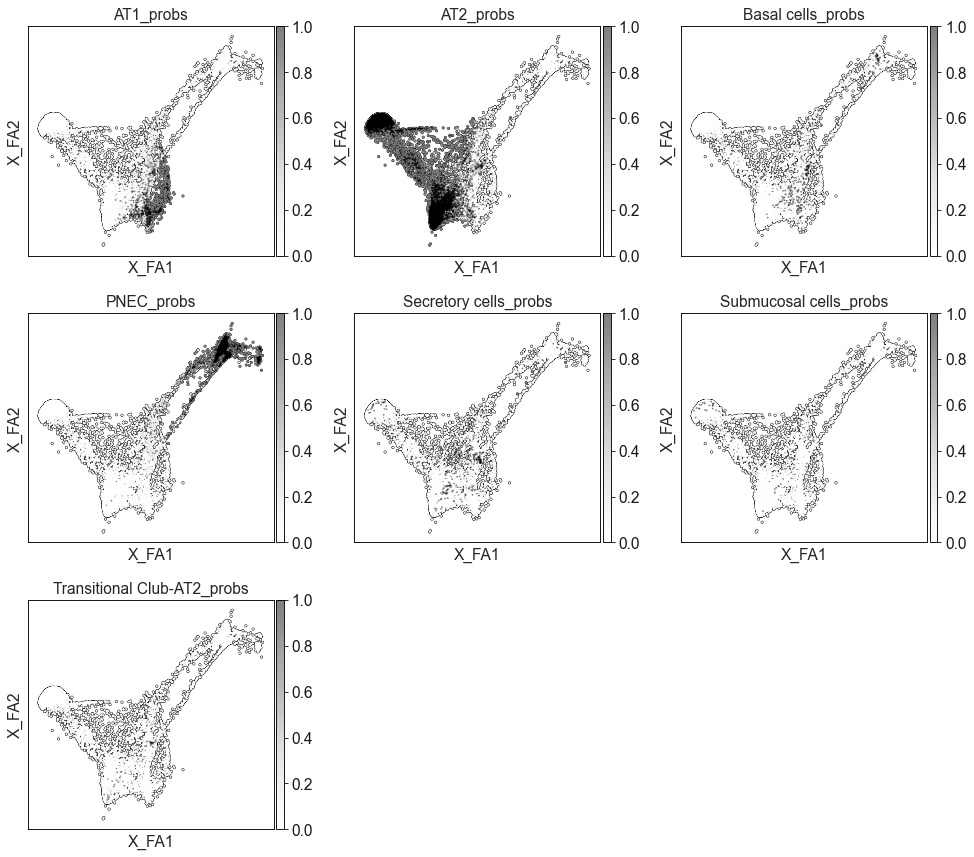

In [86]:
# Visualize on merged FDL, subset to HT samples:
# This graph projection is different than original due to the additional Pten related samples
# The FDL is a projection and has no influence in computations
# FDLs are graph based and cannot me "mapped" like dimensionality reduction methods such as UMAP or tSNE

sc.settings.verbosity = 4
sc.set_figure_params(dpi=80, dpi_save=300) 

sc.pl.embedding(adata[np.array(adata.obs['sample'].map(lambda x: x in ['AT2_1mo', 'ERPMT_pool', 'ERPMT_doxMRD',
                                                                       'ERPMT_3moMRD', 'transformed_SCLC'])).astype(bool)],
                basis='X_draw_graph_fa',
                color=lineages_list,
                ncols=3,
                cmap='Greys',
                vmin=0,
                vmax=1,
                alpha=0.5,
                s=10,
                add_outline=True,
                save='_HT_dataset_probs_FDLs.png')

## 3D PCA

In [87]:
probs_list = ['AT1_probs', 'AT2_probs', 'Basal cells_probs', 'PNEC_probs', 'Secretory cells_probs',
              'Submucosal cells_probs', 'Transitional Club-AT2_probs', 'Multiciliated cells_probs']

In [88]:
# To visualize the full TEC probability space, perform PCA:

df = adata.obs[probs_list+['sample', 'cellAssign_results']].copy()

pca = sklearn.decomposition.PCA(n_components=8)
pca_result = pca.fit_transform(df[probs_list].values)
df['PC1'] = pca_result[:,0]
df['PC2'] = pca_result[:,1] 
df['PC3'] = pca_result[:,2] 
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.6240346  0.28070438 0.0514317  0.0212866  0.01198775 0.00674414
 0.00310021 0.00071061]


In [89]:
output_dir

'/workdir/varmus_single_cell/merged_pipeline_out/Lineage_Prob_Visuals_pubShare/'

/usr/local/lib/python3.7/dist-packages/matplotlib/collections.py:1120: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


/workdir/varmus_single_cell/merged_pipeline_out/Lineage_Prob_Visuals_pubShare//Lineage_Probs_PCA_3D_color_Macro_Cell_Type.png


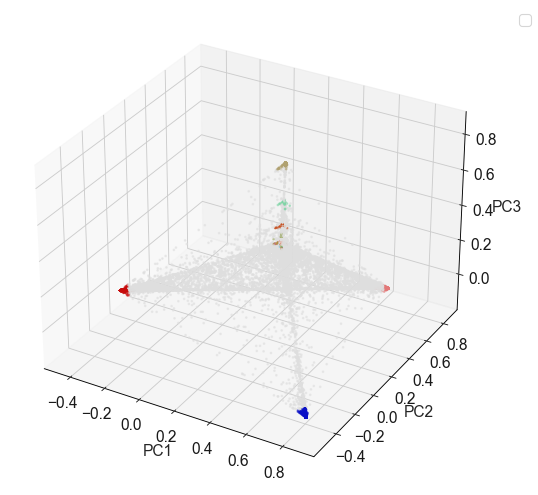

In [91]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

# axes instance
fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)

# get colormap from seaborn
cmap = cell_type_cmap
hue = [cmap[x] for x in df['cellAssign_results']]

# generate data
x = df['PC1']
y = df['PC2']
z = df['PC3']

# plot
sc_plot = ax.scatter(x, y, z, s=2, c=hue, marker='o', alpha=0.5)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

# legend
plt.legend(*sc_plot.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)

# save
fn = output_dir + f'/Lineage_Probs_PCA_3D_color_Macro_Cell_Type.png'
plt.tight_layout()

print(fn)
plt.savefig(fn, dpi=400)

In [92]:
df['Main_max_prob_name'] = df[['AT1_probs', 'AT2_probs', 'Basal cells_probs', 'PNEC_probs', 'Multiciliated cells_probs', 'Secretory cells_probs']].idxmax(axis=1).values
df['Main_max_prob'] = df[['AT1_probs', 'AT2_probs', 'Basal cells_probs', 'PNEC_probs', 'Multiciliated cells_probs', 'Secretory cells_probs']].max(axis=1).values

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


/workdir/varmus_single_cell/merged_pipeline_out/Lineage_Prob_Visuals_pubShare//Lineage_Probs_PCA_3D_color_Probs_Overlaid.png


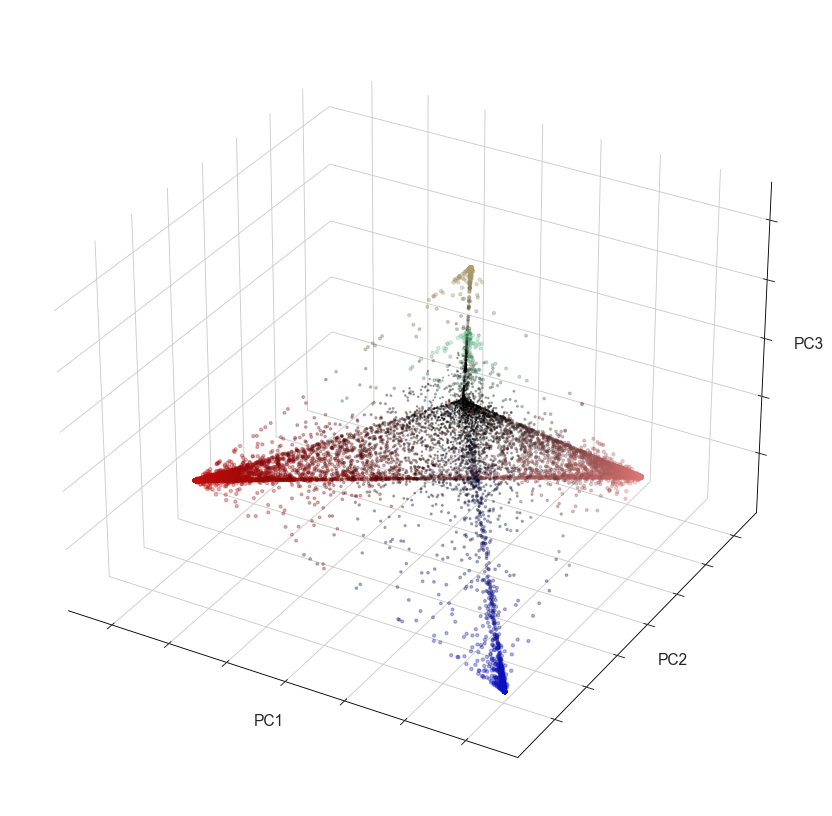

In [93]:
# axes instance
fig = plt.figure(figsize=(10,10))
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)

for n in df['Main_max_prob_name'].unique():
    
    tmp_cmap=mpl.colors.LinearSegmentedColormap.from_list('tmp cmap', ['#000000', cell_type_cmap[n.split('_probs')[0]]], N=250)
    norm = mpl.colors.Normalize(vmin=0.1, vmax=1)
        
    df_tmp = df[np.array(df['Main_max_prob_name'] == n).astype(bool)]
    
                        
    x = df_tmp['PC1']
    y = df_tmp['PC2']
    z = df_tmp['PC3']
    
    # get colormap from seaborn
    hue = [tmp_cmap(norm(x)) for x in df_tmp['Main_max_prob']]
    sizes = [10*x for x in df_tmp['Main_max_prob']]
    
    # plot
    sc_plot = ax.scatter(x, y, z, s=sizes, c=hue, marker='o', alpha=0.3)
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')


ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
            
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

fn = output_dir + f'/Lineage_Probs_PCA_3D_color_Probs_Overlaid.png'
plt.tight_layout()

print(fn)
plt.savefig(fn, dpi=400, bbox_inches='tight', transparent=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


/workdir/varmus_single_cell/merged_pipeline_out/Lineage_Prob_Visuals_pubShare//Lineage_Probs_PCA_3D_color_Probs_Overlaid_Traj_Samples.png


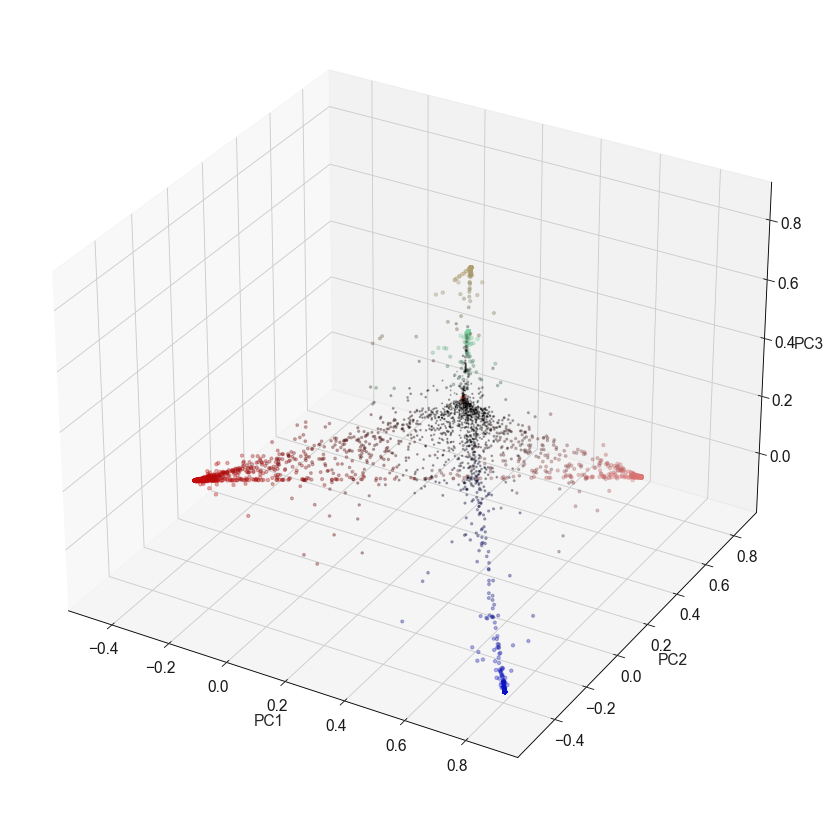

In [94]:
# axes instance
fig = plt.figure(figsize=(10,10))
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)

sample_list = ['AT2_1mo', 'ERPMT_pool', 'ERPMT_doxMRD', 'ERPMT_3moMRD', 'transformed_SCLC']

df_s = df[df['sample'].map(lambda x: x in sample_list)]

for n in df_s['Main_max_prob_name'].unique():
    
    #print(n)
    
    tmp_cmap=mpl.colors.LinearSegmentedColormap.from_list('tmp cmap', ['#000000', cell_type_cmap[n.split('_probs')[0]]], N=250)
    norm = mpl.colors.Normalize(vmin=0.1, vmax=1)


    df_tmp = df_s[np.array(df_s['Main_max_prob_name'] == n).astype(bool)]
    
                        
    x = df_tmp['PC1']
    y = df_tmp['PC2']
    z = df_tmp['PC3']
    
    # get colormap from seaborn
    hue = [tmp_cmap(norm(x)) for x in df_tmp['Main_max_prob']]
    sizes = [10*x for x in df_tmp['Main_max_prob']]
    
    # plot
    sc_plot = ax.scatter(x, y, z, s=sizes, c=hue, marker='o', alpha=0.3)
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')


            
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

fn = output_dir + f'/Lineage_Probs_PCA_3D_color_Probs_Overlaid_Traj_Samples.png'
plt.tight_layout()

print(fn)
plt.savefig(fn, dpi=400, bbox_inches='tight', transparent=True)

## Get Lineage Probs, n=6 Archetypes

### Recompute ARCHs

In [96]:
# Compute Archeytpes on lineage PCA:
optimal_noc = 6

XC_n6, S_n6, C_n6, SSE_n6, varexpl_n6 = PCHA(pca_result.T, noc=optimal_noc, delta=0.05)
archetypes_n6 = pd.DataFrame(data = np.squeeze(np.asarray(XC_n6)).T, columns = [f'PC{x+1}' for x in range(len(pca_result.T))])


### Import ARCHs

In [ ]:
# Archetypes have some degree of randomness in the computation. While rerunning the above code will produce consistent results,
# to visualize identical results from what was published, read in the saved archetypes from GitHub:

In [97]:
archetypes_n6 = pd.read_csv(f'/workdir/varmus_single_cell/code/github_notebooks/Lineage_Probs_PCA_ARCHETYPES_n6_MERGED.csv', index_col=0)

In [99]:
archetypes_n6

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
0,0.395400,0.139431,0.422701,0.143330,0.247263,0.016443,0.008243,0.000114
1,0.400232,0.140991,0.657452,0.682078,-0.553258,0.110250,0.017608,0.001296
2,0.414185,0.146283,0.885811,-0.676973,-0.194485,0.025354,0.005347,0.000095
3,0.896953,-0.536973,-0.079453,-0.010511,-0.008471,0.003718,0.000851,-0.000016
4,-0.457280,-0.047727,-0.022164,-0.003348,-0.002943,0.000909,0.000195,0.000010
5,0.618830,0.862396,-0.125870,-0.016259,-0.011618,0.004267,0.000591,0.026811


### Assign To Nearest Archetype

In [108]:
# Original cmap if importing from Github:
archetype_n6_cmap = {'ARC1': '#A7A7A7',
                     'ARC2': cell_type_cmap['Basal cells'], 
                     'ARC3': cell_type_cmap['Secretory cells'], 
                     'ARC4': cell_type_cmap['PNEC'], 
                     'ARC5': cell_type_cmap['AT2'], 
                     'ARC6': cell_type_cmap['AT1'], 
                     'None': '#E7E7E7'}

In [109]:
# Compute distance between each cell and archetype
# Archetypes are not actual data points. This code finds the cell nearest each archetype:

archetype_distances_n6 = pd.DataFrame(index = adata.obs.index)

for current_archetype_idx in np.arange(archetypes_n6.shape[0]):
    
    current_archetype = archetypes_n6.iloc[current_archetype_idx,:]
    
    distances = np.sqrt(((current_archetype.values-pca_result)**2).sum(axis = 1))
    
    archetype_distances_n6[f'ARC{current_archetype_idx+1}'] = distances

In [110]:
adata.obs['Nearest_Archetype_n6'] = archetype_distances_n6.idxmin(axis=1).astype('category')

adata.uns['Nearest_Archetype_n6_colors'] = [archetype_n6_cmap[x] for x in sorted(adata.obs['Nearest_Archetype_n6'].unique())]

In [111]:
df['Nearest_Archetype_n6'] = adata.obs['Nearest_Archetype_n6']

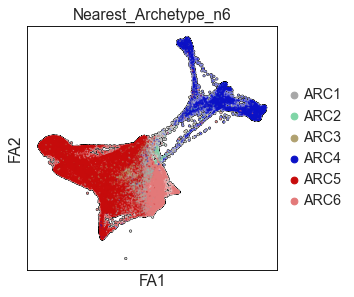

In [112]:
sc.settings.verbosity = 4
sc.set_figure_params(dpi=80, dpi_save=300) 

sc.pl.draw_graph(adata,
                 color=['Nearest_Archetype_n6'],
                 alpha=0.5,
                 s=10,
                 add_outline=True)

In [113]:
adata

AnnData object with n_obs × n_vars = 80858 × 23308
    obs: 'mt_frac', 'totReads', 'doublet_score', 'library_size', 'sample', 'origin', 'log_library_size', 'cellAssign_results', 'Macro Cell Type', 'project_batch', 'AT1_probs', 'AT2_probs', 'Basal cells_probs', 'Chondrocytes_probs', 'Multiciliated cells_probs', 'Transitional Club-AT2_probs', 'Ionocyte_probs', 'Tuft_probs', 'Secretory cells_probs', 'Submucosal cells_probs', 'PNEC_probs', 'Nearest_Archetype_n6'
    var: 'gene_ids', 'n_cells_by_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Macro Cell Type_colors', 'Project_colors', 'cellAssign_results_colors', 'draw_graph', 'hvg', 'pca', 'sample_colors', 'umap', 'origin_colors', 'Nearest_Archetype_n6_colors'
    obsm: 'DC', 'X_OG_draw_graph_fa', 'X_draw_graph_fa', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'X', 'X_impute', 'logX'

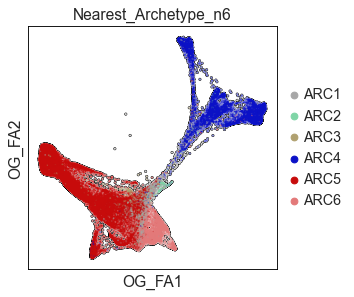

In [127]:
sc.settings.verbosity = 4
sc.set_figure_params(dpi=80, dpi_save=300) 

sc.pl.embedding(adata,
                basis='OG_draw_graph_fa',
                color=['Nearest_Archetype_n6'],
                alpha=0.5,
                s=10,
                add_outline=True)

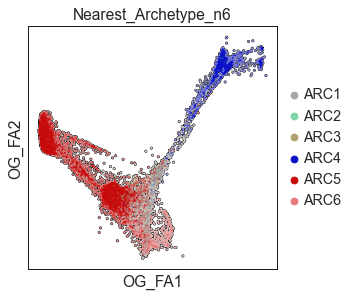

In [128]:
sc.settings.verbosity = 4
sc.set_figure_params(dpi=80, dpi_save=300) 

traj_sample_list = ['AT2_1mo', 'ERPMT_pool', 'ERPMT_doxMRD', 'ERPMT_3moMRD', 'transformed_SCLC']

sc.pl.embedding(adata[np.array(adata.obs['sample'].map(lambda x: x in traj_sample_list)).astype(bool)],
                basis='OG_draw_graph_fa',
                color=['Nearest_Archetype_n6'],
                alpha=0.5,
                s=10,
                add_outline=True,  
                save= '_TRAJ_Nearest_Archetype_n6.png')

/workdir/varmus_single_cell/merged_pipeline_out/Lineage_Prob_Visuals_pubShare//Lineage_Probs_PCA_3D_color_Probs_Overlaid_ARCHETYPES_n6.png


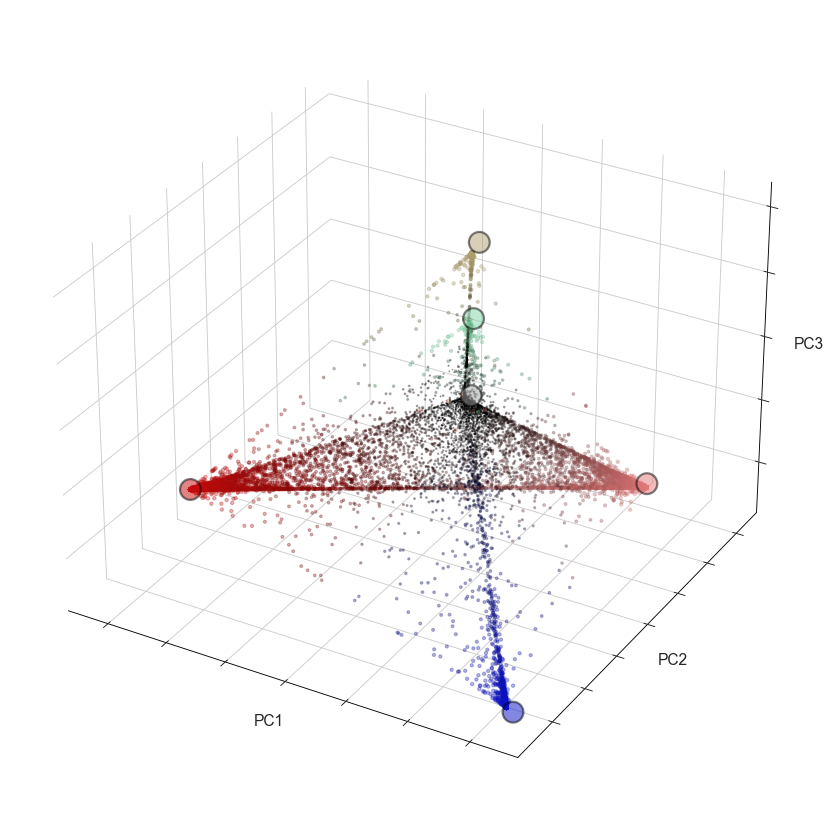

In [129]:
# Main visual:

# axes instance
fig = plt.figure(figsize=(10,10))
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)

for n in df['Main_max_prob_name'].unique():
    
    #print(n)
    
    tmp_cmap=mpl.colors.LinearSegmentedColormap.from_list('tmp cmap', ['#000000', cell_type_cmap[n.split('_probs')[0]]], N=250)
    norm = mpl.colors.Normalize(vmin=0.1, vmax=1)
        
    df_tmp = df[np.array((df['Main_max_prob_name'] == n)).astype(bool)]
    
    x = df_tmp['PC1']
    y = df_tmp['PC2']
    z = df_tmp['PC3']
    
    # get colormap from seaborn
    hue = [tmp_cmap(norm(x)) for x in df_tmp['Main_max_prob']]
    sizes = [10*x for x in df_tmp['Main_max_prob']]
    
    # plot
    sc_plot = ax.scatter(x, y, z, s=sizes, c=hue, marker='o', alpha=0.3)
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
            
# Add Archetypes:
x = archetypes_n6['PC1']
y = archetypes_n6['PC2']
z = archetypes_n6['PC3']

hue = [archetype_n6_cmap[f'ARC{x+1}'] for x in range(len(archetypes_n6))]

sc_plot = ax.scatter(x, y, z, s=350, c=hue, marker='o', edgecolor='#000000', linewidth=2, alpha=0.5)

ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])

buffer = 0.05

ax.set_xlim([df['PC1'].min()-buffer, df['PC1'].max()+buffer])
ax.set_ylim([df['PC2'].min()-buffer, df['PC2'].max()+buffer])
ax.set_zlim([df['PC3'].min()-0.1*buffer, df['PC3'].max()])    # A buffer shouldn't be needed for top of z-axis because of viewing angle
    
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

fn = output_dir + f'/Lineage_Probs_PCA_3D_color_Probs_Overlaid_ARCHETYPES_n6.png'
#plt.tight_layout()

print(fn)
plt.savefig(fn, dpi=600, bbox_inches='tight', transparent=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


/workdir/varmus_single_cell/merged_pipeline_out/Lineage_Prob_Visuals_pubShare//Lineage_Probs_PCA_3D_color_ARC_Overlaid_ARCHETYPES_n6.png


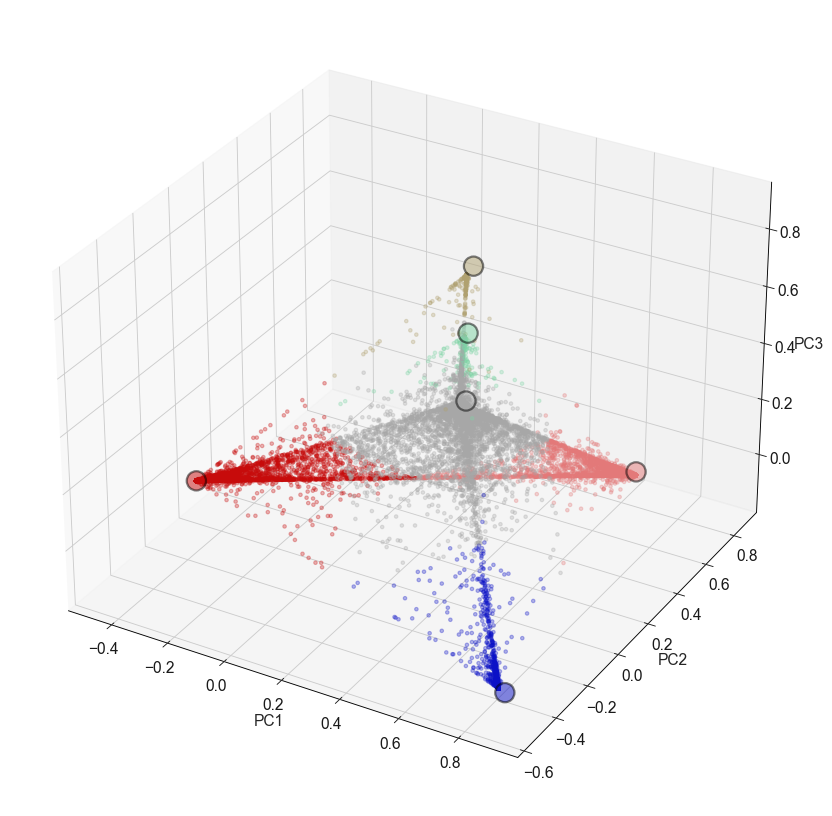

In [130]:
# axes instance
fig = plt.figure(figsize=(10,10))
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)

df_tmp = df

x = df_tmp['PC1']
y = df_tmp['PC2']
z = df_tmp['PC3']

# get colormap from seaborn
hue = [archetype_n6_cmap[x] for x in df_tmp['Nearest_Archetype_n6']]
#sizes = [10*x for x in df_tmp['Main_max_prob']]

# plot
sc_plot = ax.scatter(x, y, z, s=10, c=hue, marker='o', alpha=0.3)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
            
# Add Archetypes:
x = archetypes_n6['PC1']
y = archetypes_n6['PC2']
z = archetypes_n6['PC3']

hue = [archetype_n6_cmap[f'ARC{x+1}'] for x in range(len(archetypes_n6))]

sc_plot = ax.scatter(x, y, z, s=300, c=hue, marker='o', edgecolor='#000000', linewidth=2, alpha=0.5)

            
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

fn = output_dir + f'/Lineage_Probs_PCA_3D_color_ARC_Overlaid_ARCHETYPES_n6.png'
plt.tight_layout()

print(fn)
plt.savefig(fn, dpi=400, bbox_inches='tight', transparent=True)

#### Define Soft Clusters in PC Space

In [131]:
# Find closest cell to each archetype:

arch_cellid_map = {}
cellid_arch_map = {}

for arc in archetype_distances_n6:
    
    arch_cellid_map[arc] = archetype_distances_n6[arc].argmin(axis=0)
    cellid_arch_map[archetype_distances_n6[arc].idxmin(axis=0)] = arc

In [132]:
arch_cellid_map

{'ARC1': 38671,
 'ARC2': 11560,
 'ARC3': 24629,
 'ARC4': 73,
 'ARC5': 57285,
 'ARC6': 49196}

In [133]:
cellid_arch_map

{'CCTACGTAGCTAAACA-1-9-0': 'ARC1',
 'GTTGCTCTCAATGTCG-1-20-0': 'ARC2',
 'GCACGGTTCCATCACC-1-14-0': 'ARC3',
 'GATGACTGTGAATTAG-1-14-0': 'ARC4',
 'GACTCAACAGAGACTG-1-17-0': 'ARC5',
 'TCAGTTTAGTCTCCTC-1-13-0': 'ARC6'}

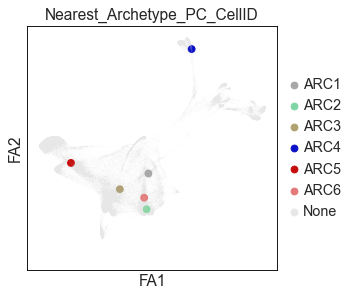

In [134]:
# While the CellIDs are defined by, and most relevant to, the PC space, useful to check out on FDL.
# Note, the soft clusteres are defined in PC space, not "FDL" or transcriptome

adata.obs['Nearest_Archetype_PC_CellID'] = [cellid_arch_map[x] if x in cellid_arch_map.keys() else 'None' for x in adata.obs.index]

adata.uns['Nearest_Archetype_PC_CellID_colors'] = [archetype_n6_cmap[x] for x in sorted(adata.obs['Nearest_Archetype_PC_CellID'].unique())]


sc.pl.draw_graph(adata, 
                 s=[200 if x != 'None' else 0.5 for x in adata.obs['Nearest_Archetype_PC_CellID']],
                 alpha=[1 if x != 'None' else 0.1 for x in adata.obs['Nearest_Archetype_PC_CellID']],
                 color='Nearest_Archetype_PC_CellID')

In [135]:
# Compute distance between each cell and archetype:

assignments = pd.DataFrame(index = adata.obs.index, 
                           columns = ['Archetype_Soft_Cluster'],
                           data = np.zeros(adata.obs.shape[0]).astype(int))

for arch in archetype_distances_n6:
    
    arch_cellid_pca = pca_result[archetype_distances_n6[arch].argmin(),:]
    
    distances = np.sqrt(((arch_cellid_pca-pca_result)**2).sum(axis = 1))
    
    #distances = distances[distances!=0]
    
    arc_distances = distances[list(arch_cellid_map.values())]
    arc_distances_min = arc_distances[arc_distances!=0].min()
    
    arch_radius = 0.25*arc_distances_min
    tmp = (distances < arch_radius)
    
    assignments[tmp == True] = arch

In [136]:
assignments['Archetype_Soft_Cluster'].value_counts()

ARC5    47358
ARC4    14341
ARC6     9587
0        4395
ARC1     3476
ARC3     1044
ARC2      657
Name: Archetype_Soft_Cluster, dtype: int64

In [138]:
adata.obs['Nearest_Archetype_PC'] = assignments.loc[adata.obs.index.tolist(),:].astype(str).replace('0', 'None')

adata.uns['Nearest_Archetype_PC_colors'] = [archetype_n6_cmap[x] for x in sorted(adata.obs['Nearest_Archetype_PC'].unique())]

In [139]:
adata.obs['Nearest_Archetype_PC'].value_counts()

ARC5    47358
ARC4    14341
ARC6     9587
None     4395
ARC1     3476
ARC3     1044
ARC2      657
Name: Nearest_Archetype_PC, dtype: int64

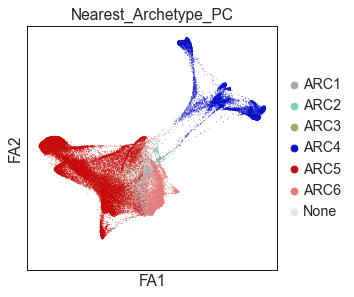

In [140]:
sc.pl.draw_graph(adata, color=['Nearest_Archetype_PC'])

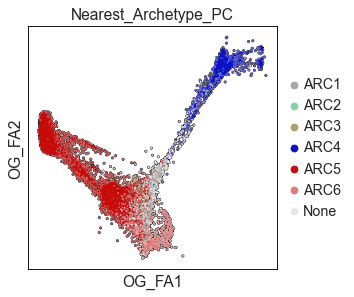

In [145]:
sc.pl.embedding(adata[np.array(adata.obs['sample'].map(lambda x: x in traj_sample_list)).astype(bool)],
                 basis='OG_draw_graph_fa',
                 color=['Nearest_Archetype_PC'], add_outline=True, s=10, alpha=0.75, save='_Traj_Nearest_Arch_PC_FDL.png')

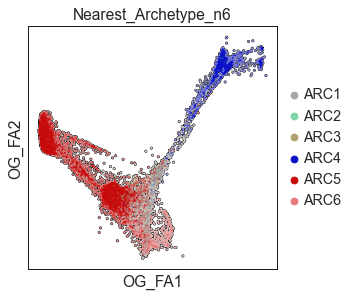

In [146]:
sc.pl.embedding(adata[np.array(adata.obs['sample'].map(lambda x: x in traj_sample_list)).astype(bool)], 
                 basis='OG_draw_graph_fa',
                 color=['Nearest_Archetype_n6'], add_outline=True, s=10, alpha=0.5, save='_Traj_Nearest_Arch_n6_FDL.png')

In [143]:
df['Nearest_Archetype_PC'] = adata.obs['Nearest_Archetype_PC']

/workdir/varmus_single_cell/merged_pipeline_out/Lineage_Prob_Visuals_pubShare//Lineage_Probs_PCA_3D_color_Nearest_Archetype_PC_Overlaid_ARCHETYPES_n6.png


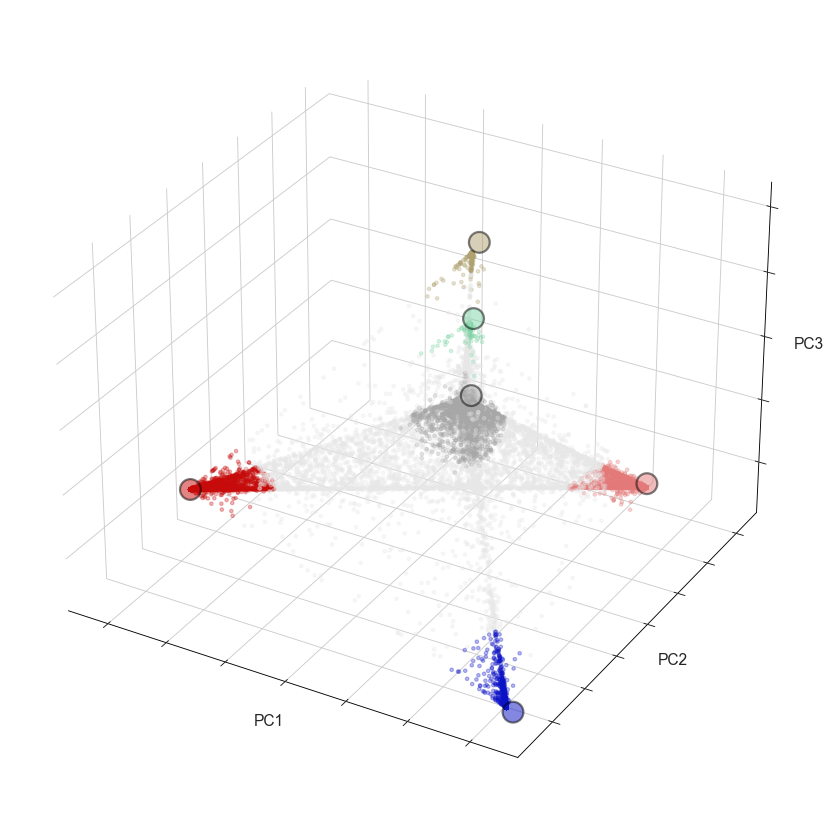

In [144]:
# Soft cluster PCA (shown in supplement):

# axes instance
fig = plt.figure(figsize=(10,10))
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)


df_tmp = df

x = df_tmp['PC1']
y = df_tmp['PC2']
z = df_tmp['PC3']

# get colormap from seaborn
hue = [archetype_n6_cmap[x] for x in df_tmp['Nearest_Archetype_PC']]
#sizes = [10*x for x in df_tmp['Main_max_prob']]

# plot
sc_plot = ax.scatter(x, y, z, s=10, c=hue, marker='o', alpha=0.3)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

            
# Add Archetypes:
x = archetypes_n6['PC1']
y = archetypes_n6['PC2']
z = archetypes_n6['PC3']

hue = [archetype_n6_cmap[f'ARC{x+1}'] for x in range(len(archetypes_n6))]

sc_plot = ax.scatter(x, y, z, s=350, c=hue, marker='o', edgecolor='#000000', linewidth=2, alpha=0.5)

ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])

buffer = 0.05

ax.set_xlim([df['PC1'].min()-buffer, df['PC1'].max()+buffer])
ax.set_ylim([df['PC2'].min()-buffer, df['PC2'].max()+buffer])
ax.set_zlim([df['PC3'].min()-0.1*buffer, df['PC3'].max()])    # A buffer shouldn't be needed for top of z-axis because of viewing angle

fn = output_dir + f'/Lineage_Probs_PCA_3D_color_Nearest_Archetype_PC_Overlaid_ARCHETYPES_n6.png'
#plt.tight_layout()

print(fn)
plt.savefig(fn, dpi=400, bbox_inches='tight', transparent=True)

## Visualize Archetypes

In [147]:
# Subset to soft clusters to focus on most representative cells near each archetype

adata_sub = adata[adata.obs['Nearest_Archetype_PC'] != 'None']

In [148]:
adata_sub.shape

(76463, 23308)

In [149]:
output_dir

'/workdir/varmus_single_cell/merged_pipeline_out/Lineage_Prob_Visuals_pubShare/'

### Visualize Specific Genes

#### Download cellAssign markers and DEGs from supplementary tables

In [150]:
# Define data directory
# Data is available from published supplementary tables:

data_dir = '/workdir/varmus_single_cell/code/github_notebooks/'

markerFile = f'/{data_dir}/Supplementary_Table_1.xls'

markers_cellAssign = pd.read_excel(markerFile, index_col=0)

In [151]:
markers_cellAssign.head()

,Basal Cells,Chondrocyte,Multiciliated Cells,Secretory Cells,Transitional Club-AT2,Ionocyte,Tuft,PNEC,Submucosal,AT1,...,B cells,Plasma cells,T cells,NK cells,DCs,pDCs,Macrophages,Monocytes,Mast cells,Granulocytic
0,Fhl2,Cytl1,Igfbp5,Rims1,Vim,Tmem61,Hes6,Scg2,Apip,Clic3,...,Cd79a,Itm2c,Ms4a4b,Klrd1,Ccr7,Siglech,Folr2,Prtn3,Rgs13,S100a8
1,Clca2,Col11a1,Hes6,Rhov,Cav1,Clcnkb,Marcksl1,Scg5,Rhov,Myl9,...,Ighm,Jchain,Trac,Gzma,Ccl22,Ccr9,Slc40a1,Nkg7,Cpa3,S100a9
2,Ptprz1,Col9a2,1110017D15Rik,Tgm2,Mgp,Stap1,Stmn1,Cpe,Bpifb2,Anxa3,...,Cd79b,Cd27,Trbc2,Il2rb,H2-M2,Ly6c1,Cfp,Cst7,Kit,Retnlg
3,Igfbp3,Fam180a,Zmynd10,Rarres1,Icam1,Hepacam2,Kit,Scg3,Rarres1,Cav1,...,Iglc2,Cd79a,Cd3d,Klrb1c,Apol7c,Ly6c2,Vcam1,Lyz2,Hpgds,Cxcr2
4,Krt15,Fmod,Kif9,Clca2,Susd2,Cftr,Rassf6,Ascl1,S100a1,Spock2,...,Iglc3,Isg20,Trbc1,Klre1,Epsti1,NaN,Ear2,Ms4a6c,Gata2,Csf3r


In [152]:
# Define data directory
# Data is available from published supplementary tables:

data_dir = '/workdir/varmus_single_cell/code/github_notebooks/'

mast_outdir = f'/{data_dir}/Supplementary_Table_2.xlsx'

xls = pd.ExcelFile(mast_outdir)

In [153]:
xls.sheet_names

['Table of Contents',
 'SCLC vs LUAD DEGs',
 'SCLC vs LUAD Peaks',
 'Undifferentiated ARC1 DEGs',
 'Basal ARC2 DEGs',
 'Secretory ARC3 DEGs',
 'PNEC ARC4 DEGs',
 'AT2 ARC5 DEGs',
 'AT1 ARC6 DEGs',
 'Macrostate Prob. Gene Corr.',
 'Macrostate Prob. Regulon Corr.',
 'AT2 Macrostate GSEA',
 'LUAD Macrostate GSEA',
 'Bottleneck Macrostate GSEA',
 'Terminal SCLC Macrostate GSEA',
 'Spc>PtenMT ARC1 DEGs',
 'Spc>PtenMT ARC1 GSEA',
 'Breakout vs Bottleneck DEGs',
 'Breakout vs Bottleneck GSEA',
 'RPPtenMT Ascl1 high vs low DEGs']

In [154]:
mast_results_df = pd.DataFrame()

for x in ['Undifferentiated ARC1 DEGs',
          'Basal ARC2 DEGs',
          'Secretory ARC3 DEGs',
          'PNEC ARC4 DEGs',
          'AT2 ARC5 DEGs',
          'AT1 ARC6 DEGs']:
    
    tmp_df = read_mast_results(xls, x)
    tmp_df['MAST_Info'] = x.replace(' ', '_').replace('DEGs', 'vs_all_others_ALL_GENEs')
    mast_results_df = mast_results_df.append(tmp_df)

Reading Undifferentiated ARC1 DEGs
Reading Basal ARC2 DEGs
Reading Secretory ARC3 DEGs
Reading PNEC ARC4 DEGs
Reading AT2 ARC5 DEGs
Reading AT1 ARC6 DEGs


In [155]:
mast_results_df.head()

,p,log2FC,ci.hi,ci.lo,fdr,bonferroni,rank_score,FC,scaled_rank_score,abs_scaled_rank_score,MAST_Info
gene,,,,,,,,,,,
Clu,9.881313e-324,0.813274,0.837141,0.789407,3.438697e-321,2.114996e-319,3186.746904,1.757194,2591.697933,2591.697933,Undifferentiated_ARC1_vs_all_others_ALL_GENEs
Lgals3,9.881313e-324,0.623063,0.660767,0.585358,3.438697e-321,2.114996e-319,3186.746904,1.540141,1985.542553,1985.542553,Undifferentiated_ARC1_vs_all_others_ALL_GENEs
Krt19,9.881313e-324,0.609412,0.656561,0.562263,3.438697e-321,2.114996e-319,3186.746904,1.525637,1942.042287,1942.042287,Undifferentiated_ARC1_vs_all_others_ALL_GENEs
Ly6a,9.881313e-324,0.587345,0.622359,0.552330,3.438697e-321,2.114996e-319,3186.746904,1.502479,1871.718384,1871.718384,Undifferentiated_ARC1_vs_all_others_ALL_GENEs
Anxa1,9.881313e-324,0.540458,0.579794,0.501123,3.438697e-321,2.114996e-319,3186.746904,1.454434,1722.303711,1722.303711,Undifferentiated_ARC1_vs_all_others_ALL_GENEs


In [156]:
# Filter out Rpl, Rps, mt-, and Hsp genes
# This is an optional step here, but can be useful when performing DEG testing:
mast_genes_filter = np.array((mast_results_df.index.map(lambda x: x[:3] not in 
                                                ['Rpl', 'Rps', 'mt-', 'Hsp']))).astype(bool)
mast_results_df = mast_results_df[mast_genes_filter]

mast_results_df.index = mast_results_df.index.astype(str)

In [157]:
genes = []

for cellType in ['AT1', 'AT2', 'Basal Cells', 'PNEC', 'Secretory Cells']:
    
    genes.append(markers_cellAssign[cellType].dropna().values.tolist())
    
genes = [item for sublist in genes for item in sublist]

genes = np.unique(genes).tolist()
    
genes = genes + ['Myc' , 'Tg.Egfr',]

print('Missing Genes: ', [x for x in genes if x not in adata_sub.var.index])

genes = [x for x in genes if x in adata_sub.var.index]

# Add in mapped adult stem cell genes:
#genes = genes + mapped_genes

Missing Genes:  ['Ins1', 'NeuroD1']


In [158]:
print(len(genes))

98


##### Filter for DEGs

In [159]:
# Filter for significant results:

print(mast_results_df.shape)

mast_results_df = mast_results_df[mast_results_df.bonferroni < 0.05]

print(mast_results_df.shape)

(122535, 11)
(55592, 11)


(55592, 11)
(20319, 11)


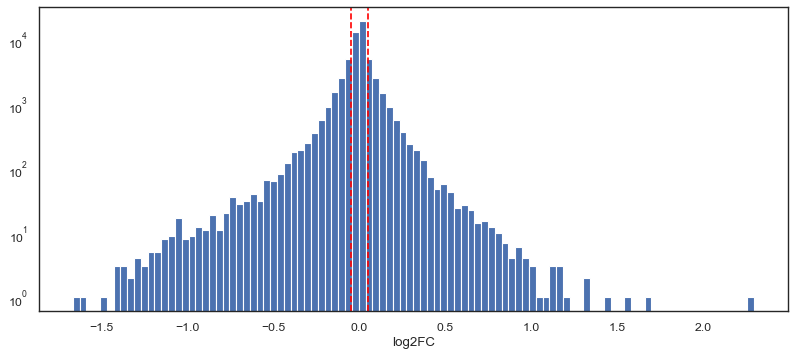

In [160]:
# Filter by logFC
# The focus here is to retain the most relevant cell lineage markers
# and clean up the dotplot, not to select the top differentially expressed genes

log2FC_thr = 0.05

sns.set(style='white')

fig, ax = plt.subplots(figsize=(12,5))

plt.hist(mast_results_df.log2FC, bins=100)

plt.axvline(log2FC_thr, linestyle='--', color='red')
plt.axvline(-log2FC_thr, linestyle='--', color='red')

plt.yscale('log')

plt.xlabel('log2FC')

# Filter for significant results:

print(mast_results_df.shape)

mast_results_df = mast_results_df[abs(mast_results_df.log2FC) > log2FC_thr]

print(mast_results_df.shape)

In [161]:
# Remove genes not meeting MAST thresholds:

print(len(genes))

genes = [x for x in genes if x in mast_results_df.index]

print(len(genes))

98
56


In [162]:
# Filter out lowly expressed genes:

arch_list = [x for x in sorted(adata_sub.obs['Nearest_Archetype_PC'].unique())]

arch_size_map = dict(zip(arch_list,
                         [adata_sub.obs['Nearest_Archetype_PC'].value_counts()[x] for x in arch_list]))

keep = []

genes_tmp = genes

for arch in adata_sub.obs['Nearest_Archetype_PC'].unique():
    
    if arch != 'None':
        
        keep += [x for x in genes if sum(np.ravel(adata_sub[adata_sub.obs['Nearest_Archetype_PC'] == arch, x].layers['logX']) > 0) 
                 / arch_size_map[arch] > 0.2]
        
        genes_tmp = [x for x in genes if x not in keep]
        
print(f'Numer of Total Genes: {len(genes)}')

genes = list(np.unique(keep))

print(f'Numer of Filtered Genes: {len(genes)}')

Numer of Total Genes: 56
Numer of Filtered Genes: 52


In [163]:
# Compute clustering for archetypes:

adata_sub.X = adata_sub.layers['logX']

sc.tl.dendrogram(adata_sub, 
                 groupby='Nearest_Archetype_PC', 
                 n_pcs=None, 
                 use_rep='X', 
                 var_names=genes, 
                 use_raw=None, 
                 cor_method='pearson', 
                 key_added='dendrogram_Nearest_Archetype_PC_DEGs',
                 linkage_method='complete')

Storing dendrogram info using `.uns['dendrogram_Nearest_Archetype_PC_DEGs']`
/usr/local/lib/python3.7/dist-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


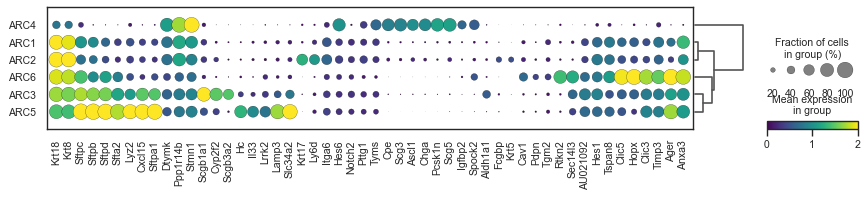

In [164]:
# Visualize on dotplot:

cat_order = adata_sub.uns['dendrogram_Nearest_Archetype_PC_DEGs']['categories_ordered']

sns.set(style='white')
sc.set_figure_params(dpi=80, dpi_save=300)

adata_sub.X = adata_sub.layers['logX']

dotplot_df = pd.DataFrame(adata_sub[:,genes].layers['logX'], 
                          index=adata_sub[:,genes].obs['Nearest_Archetype_PC'], 
                          columns=genes)

dotplot_df = dotplot_df.groupby(level=0).mean()

dotplot_df = dotplot_df.loc[cat_order,:]

method = 'average'
metric = 'cityblock'

linkage = hc.linkage(dotplot_df.T, method=method, metric=metric)
col_linkage = deepcopy(linkage)
c1 = hc.leaves_list(col_linkage)

genes = dotplot_df.iloc[:,c1].columns.tolist()

sns.set(font_scale=0.95, style='white')

sc.pl.dotplot(adata_sub,
              var_names=genes,
              groupby='Nearest_Archetype_PC',
              dendrogram='dendrogram_Nearest_Archetype_PC_DEGs',
              cmap='viridis',
              vmin=0,
              vmax=2,
              figsize=(13,2),
              save=f'_Archetype_lineage_markers_DEGs_bonferroni_0.05_log2FC_{log2FC_thr}_{method}_{metric}_dotplot.png')

sns.set(font_scale=1, style='white')

/workdir/varmus_single_cell/merged_pipeline_out/Lineage_Prob_Visuals_pubShare/Archetype_lineage_markers_DEGs_bonferroni_0.05_log2FC_0.05_average_cityblock_dendrogram.png


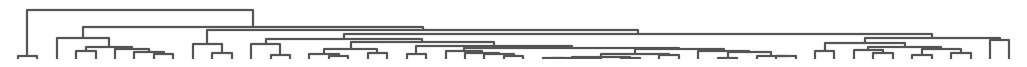

In [165]:
matplotlib.rcParams['lines.linewidth'] = 2

plt.figure(figsize=(13,1))

sns.despine()

#dn = hc.dendrogram(linkage, above_threshold_color='black', color_threshold=0, truncate_mode='level', p=5)

dn = hc.dendrogram(linkage, above_threshold_color='#555555', color_threshold=0)

sns.despine(bottom=True, left=True)

plt.xticks([])
plt.yticks([])

# save
fn = output_dir + f'Archetype_lineage_markers_DEGs_bonferroni_0.05_log2FC_{log2FC_thr}_{method}_{metric}_dendrogram.png'
plt.tight_layout()

print(fn)
plt.savefig(fn, dpi=400, bbox_inches='tight', transparent=True)

matplotlib.rcParams['lines.linewidth'] = 1.0

#### CellAssign Probabilities by Archetype

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 


/workdir/varmus_single_cell/merged_pipeline_out/Lineage_Prob_Visuals_pubShare//Nearest_Archetype_by_Lineage_CellAssign_Probs_Heatmap.png


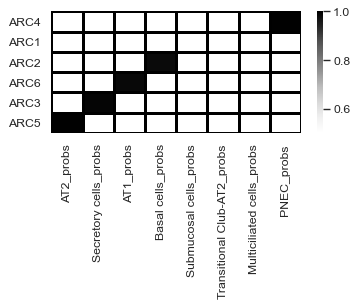

In [171]:
cat_order = adata_sub.uns['dendrogram_Nearest_Archetype_PC_DEGs']['categories_ordered']

df = adata_sub.obs[probs_list+['Nearest_Archetype_PC']].groupby('Nearest_Archetype_PC').mean()

fig,ax = plt.subplots(figsize=(5,2))

sns.heatmap(df.loc[cat_order,
                   ['AT2_probs', 'Secretory cells_probs', 'AT1_probs', 'Basal cells_probs', 
                    'Submucosal cells_probs', 'Transitional Club-AT2_probs', 'Multiciliated cells_probs', 'PNEC_probs']],
            cmap='Greys',
            vmin=0.5,
            vmax=1,
            linewidths=1, 
            linecolor='Black')

plt.ylabel('')

# save
fn = output_dir + f'/Nearest_Archetype_by_Lineage_CellAssign_Probs_Heatmap.png'
plt.tight_layout()

print(fn)
plt.savefig(fn, dpi=400, bbox_inches='tight', transparent=True)

#### Large Gene Sets Heatmap

#### Mean Expression Heatmap

In [177]:
# Import gene sets from supplementary tables:
data_dir = '/workdir/varmus_single_cell/code/github_notebooks/'

geneset_outdir = f'/{data_dir}/Supplementary_Table_3.xlsx'

xls2 = pd.ExcelFile(geneset_outdir)

In [178]:
xls2.sheet_names

['HALLMARK.gmt', 'Lung_Tissue_Signatures.gmt']

In [179]:
HALLMARKS = pd.read_excel(xls2, 'HALLMARK.gmt').T.reset_index()

HALLMARKS.columns = HALLMARKS.loc[0,:]

HALLMARKS = HALLMARKS.loc[2:,]

In [182]:
HALLMARKS.head()

,HALLMARK_ADIPOGENESIS,HALLMARK_ALLOGRAFT_REJECTION,HALLMARK_ANDROGEN_RESPONSE,HALLMARK_ANGIOGENESIS,HALLMARK_APICAL_JUNCTION,HALLMARK_APICAL_SURFACE,HALLMARK_APOPTOSIS,HALLMARK_BILE_ACID_METABOLISM,HALLMARK_CHOLESTEROL_HOMEOSTASIS,HALLMARK_COAGULATION,...,HALLMARK_PROTEIN_SECRETION,HALLMARK_REACTIVE_OXYGEN_SPECIES_PATHWAY,HALLMARK_SPERMATOGENESIS,HALLMARK_TGF_BETA_SIGNALING,HALLMARK_TNFA_SIGNALING_VIA_NFKB,HALLMARK_UNFOLDED_PROTEIN_RESPONSE,HALLMARK_UV_RESPONSE_DN,HALLMARK_UV_RESPONSE_UP,HALLMARK_WNT_BETA_CATENIN_SIGNALING,HALLMARK_XENOBIOTIC_METABOLISM
2,ABCA1,AARS1,ABCC4,APOH,ACTA1,ADAM10,ADD1,ABCA1,ABCA2,A2M,...,ABCA1,ABCC1,ACE,ACVR1,ABCA1,ALDH18A1,ABCC1,ABCB1,ADAM17,ABCC2
3,ABCB8,ABCE1,ABHD2,APP,ACTB,ADIPOR2,AIFM3,ABCA2,ACAT2,ACOX2,...,ADAM10,ATOX1,ACRBP,APC,ACKR3,ARFGAP1,ACVR2A,ACAA1,AXIN1,ABCC3
4,ACAA2,ABI1,ACSL3,CCND2,ACTC1,AFAP1L2,ANKH,ABCA3,ACSS2,ADAM9,...,ANP32E,CAT,ACRV1,ARID4B,AREG,ASNS,ADD3,AGO2,AXIN2,ABCD2
5,ACADL,ACHE,ACTN1,COL3A1,ACTG1,AKAP7,ANXA1,ABCA4,ACTG1,ANG,...,AP1G1,CDKN2D,ACTL7B,BCAR3,ATF3,ATF3,ADGRL2,ALAS1,CCND2,ABHD6
6,ACADM,ACVR2A,ADAMTS1,COL5A2,ACTG2,APP,APP,ABCA5,ADH4,ANXA1,...,AP2B1,EGLN2,ADAD1,BMP2,ATP2B1,ATF4,ADORA2B,ALDOA,CSNK1E,ACO2


In [183]:
lung_sigs = pd.read_excel(xls2, 'Lung_Tissue_Signatures.gmt').T.reset_index()

lung_sigs.columns = lung_sigs.loc[0,:]

lung_sigs = lung_sigs.loc[2:,]

In [184]:
mapped_genes = [("" if x.upper() in mToH_mapping.values() else x.upper()) 
                    if x not in mToH_mapping else mToH_mapping[x] for x in adata_sub.var.index]

for col in ['ES_EXP1_BENPORATH', 'ES_EXP2_BENPORATH', 'HALLMARK_MYC_TARGETS_V1', 'HALLMARK_MYC_TARGETS_V2', 
            'ES_TFS_BENPORATH', 'SOX2_TARGETS_BENPORATH']:
    
    # Check if each map mouse gene is in current signature:
    current_mapped_genes = [x for x in range(len(mapped_genes)) if mapped_genes[x] in lung_sigs[col].values.tolist()]
    
    print(f'{col} Genes Mapped:', len(current_mapped_genes), '/', len([x for x in lung_sigs[col].dropna().values.tolist() if type(x) != float]))
    
    # Compute mean expression vector of current signature:
    adata_sub.obs[f'{col}_mean_logX'] = np.array(adata_sub[:,current_mapped_genes].layers['logX'].mean(axis=1))
    adata_sub.obs[col+'_znorm_mean_logX'] = scipy.stats.zscore(adata_sub.obs[f'{col}_mean_logX'])

    # Imputed
    adata_sub.obs[f'{col}_mean_X_impute'] = np.array(adata_sub[:,current_mapped_genes].layers['X_impute'].mean(axis=1))
    adata_sub.obs[col+'_znorm_mean_X_impute'] = scipy.stats.zscore(adata_sub.obs[f'{col}_mean_X_impute'])

ES_EXP1_BENPORATH Genes Mapped: 306 / 380
ES_EXP2_BENPORATH Genes Mapped: 27 / 40
HALLMARK_MYC_TARGETS_V1 Genes Mapped: 186 / 200
HALLMARK_MYC_TARGETS_V2 Genes Mapped: 57 / 58
ES_TFS_BENPORATH Genes Mapped: 65 / 68
SOX2_TARGETS_BENPORATH Genes Mapped: 577 / 734


In [185]:
for col in ['AT1', 'AT2', 'Basal Cells', 'PNEC', 'Secretory Cells']:
    
    # Check if each map mouse gene is in current signature:
    current_mapped_genes = [x for x in range(len(adata_sub.var)) if adata_sub.var.index[x] in markers_cellAssign[col].values.tolist()]
    
    # Compute mean expression vector of current signature:
    adata_sub.obs[f'{col}_mean_logX'] = np.array(adata_sub[:,current_mapped_genes].layers['logX'].mean(axis=1))
    adata_sub.obs[col+'_znorm_mean_logX'] = scipy.stats.zscore(adata_sub.obs[f'{col}_mean_logX'])
    
    # Imputed
    adata_sub.obs[f'{col}_mean_X_impute'] = np.array(adata_sub[:,current_mapped_genes].layers['X_impute'].mean(axis=1))
    adata_sub.obs[col+'_znorm_mean_X_impute'] = scipy.stats.zscore(adata_sub.obs[f'{col}_mean_X_impute'])

In [186]:
col = 'PNEC'
    
# Check if each map mouse gene is in current signature:
current_mapped_genes = [x for x in range(len(adata_sub.var)) if adata_sub.var.index[x] in markers_cellAssign[col].values.tolist()]

# Compute mean expression vector of current signature:
adata_sub.obs[f'{col}_mean_logX'] = np.array(adata_sub[:,current_mapped_genes].layers['logX'].mean(axis=1))
adata_sub.obs[col+'_znorm_mean_logX'] = scipy.stats.zscore(adata_sub.obs[f'{col}_mean_logX'])

# Imputed
adata_sub.obs[f'{col}_mean_X_impute'] = np.array(adata_sub[:,current_mapped_genes].layers['X_impute'].mean(axis=1))
adata_sub.obs[col+'_znorm_mean_X_impute'] = scipy.stats.zscore(adata_sub.obs[f'{col}_mean_X_impute'])

In [187]:
# MPAS signature from:
# https://www.nature.com/articles/s41698-018-0051-4

mpas_genes = ['PHLDA1', 'SPRY2', 'SPRY4', 'DUSP4', 'DUSP6', 'CCND1', 'EPHA2', 'EPHA4', 'ETV4', 'ETV5']

# Map mouse genes to human:
mapped_genes = [("" if x.upper() in mToH_mapping.values() else x.upper()) 
                 if x not in mToH_mapping else mToH_mapping[x] for x in adata_sub.var.index]

# Check if each map mouse gene is in current signature:
current_mapped_genes = [x for x in range(len(mapped_genes)) 
                        if mapped_genes[x] in mpas_genes]

# Compute mean expression vector of current signature:
col = 'MPAS'
adata_sub.obs[f'{col}_mean_logX'] = np.array(adata_sub[:,current_mapped_genes].layers['logX'].mean(axis=1))
adata_sub.obs[col+'_znorm_mean_logX'] = scipy.stats.zscore(adata_sub.obs[f'{col}_mean_logX'])
# Imputed
adata_sub.obs[f'{col}_mean_X_impute'] = np.array(adata_sub[:,current_mapped_genes].layers['X_impute'].mean(axis=1))
adata_sub.obs[col+'_znorm_mean_X_impute'] = scipy.stats.zscore(adata_sub.obs[f'{col}_mean_X_impute'])

In [188]:
pathway_list = ['AT1', 'AT2', 'Basal Cells', 'Secretory Cells', 'PNEC', 
                'ES_EXP1_BENPORATH', 'ES_EXP2_BENPORATH', 'SOX2_TARGETS_BENPORATH',
                'HALLMARK_MYC_TARGETS_V1', 'HALLMARK_MYC_TARGETS_V2']

metric = '_znorm_mean_logX'

df = adata_sub.obs[[x+metric for x in pathway_list]]

df.index = adata_sub.obs['Nearest_Archetype_PC']

df = df.reset_index().groupby('Nearest_Archetype_PC').median()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


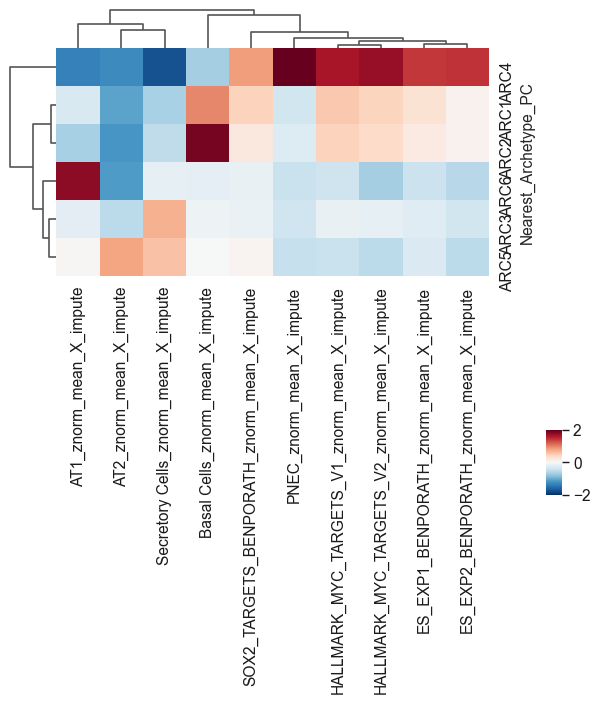

In [196]:
# This heatmap takes the median of the znormalized mean expression

metric = '_znorm_mean_X_impute'

df = adata_sub.obs[[x+metric for x in pathway_list]]

df.index = adata_sub.obs['Nearest_Archetype_PC']

df = df.reset_index().groupby('Nearest_Archetype_PC').median()

method = 'complete'
metric = 'cityblock'

g = sns.clustermap(data = df,
                   cmap='RdBu_r',
                   vmin=-2, 
                   vmax=2,
                   figsize=(7, 9),
                   method=method,
                   metric=metric,
                   dendrogram_ratio=(0.1, 0.15),
                   cbar_pos=(0.99, 0.3, 0.03, 0.09),
                   #linewidths=0.5, 
                   #linecolor='#555555')
                  )

for a in g.ax_row_dendrogram.collections:
    a.set_linewidth(1.5)
    a.set_color('#555555')

for a in g.ax_col_dendrogram.collections:
    a.set_linewidth(1.5)
    a.set_color('#555555')
    
g.ax_heatmap.tick_params(right=False, bottom=False)
    
# save
fn = output_dir + f'/Nearest_Archetype_by_Lineage_CellAssign_Probs_Heatmap_logX.png'
plt.tight_layout()

#print(fn)
#plt.savefig(fn, dpi=400, bbox_inches='tight', transparent=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


/workdir/varmus_single_cell/merged_pipeline_out/Lineage_Prob_Visuals_pubShare//Znormalized_ARCH_mean_pathway_mean_logX_heatmap_average_cityblock.png


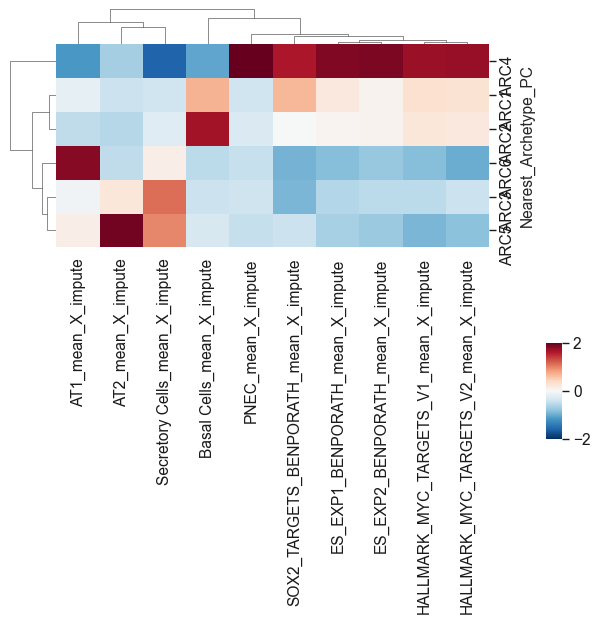

In [197]:
# This heatmap znormalized the median of the mean expression

metric = '_mean_X_impute'

df = adata_sub.obs[[x+metric for x in pathway_list]]

df.index = adata_sub.obs['Nearest_Archetype_PC']

df = df.reset_index().groupby('Nearest_Archetype_PC').median()

method = 'average'
metric = 'cityblock'

sns.clustermap(data = df,
               cmap='RdBu_r',
               vmin=-2, 
               vmax=2,
               z_score=1,
               method=method,
               metric=metric,
               figsize=(7, 8),
               dendrogram_ratio=(0.1, 0.15),
               cbar_pos=(0.99, 0.3, 0.03, 0.15))

fn = output_dir + f'/Znormalized_ARCH_mean_pathway_mean_logX_heatmap_{method}_{metric}.png'
plt.tight_layout()

print(fn)
plt.savefig(fn, dpi=400)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


/workdir/varmus_single_cell/merged_pipeline_out/Lineage_Prob_Visuals_pubShare//ARCH_mean_pathway_mean_logX_min_max_norm_heatmap_average_euclidean.png


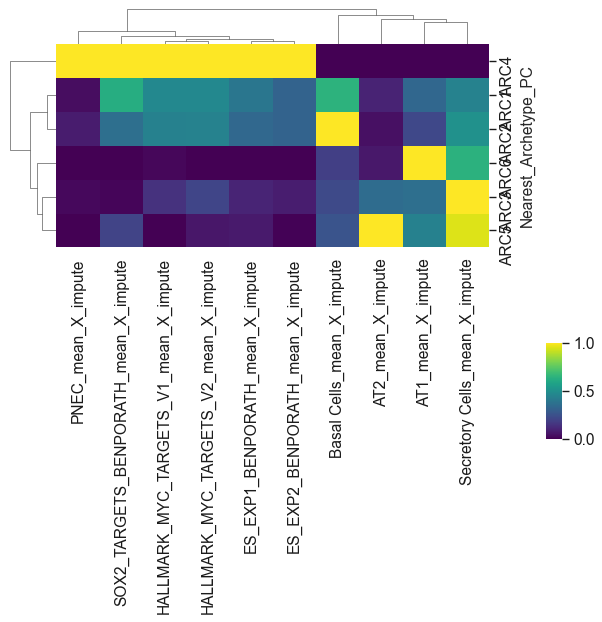

In [198]:
method = 'average'
metric = 'euclidean'

df=(df-df.min())/(df.max()-df.min())

sns.clustermap(data = df,
               cmap='viridis',
               vmin=0, 
               vmax=1,
               #z_score=1,
               method=method,
               metric=metric,
               figsize=(7, 8),
               dendrogram_ratio=(0.1, 0.15),
               cbar_pos=(0.99, 0.3, 0.03, 0.15))

fn = output_dir + f'/ARCH_mean_pathway_mean_logX_min_max_norm_heatmap_{method}_{metric}.png'
plt.tight_layout()

print(fn)
plt.savefig(fn, dpi=400)

### Archetype Flow by Sample

In [199]:
df_frac = adata.obs.groupby(['sample', 'Nearest_Archetype_n6']).size().unstack(fill_value=0)

df_frac = df_frac.div(df_frac.sum(axis=1), axis=0).T

df_frac = df_frac[['AT2_1mo', 'ERPMT_pool', 'ERPMT_doxMRD', 'ERPMT_3moMRD', 'transformed_SCLC']]

In [200]:
# Normalize by the intermediate sample size to scale total bar height:

sample_size_scale = adata.obs['sample'].value_counts().loc[df_frac.columns.tolist()].values / adata.obs['sample'].value_counts()['ERPMT_3moMRD']

df_frac_norm = df_frac * sample_size_scale

In [201]:
# Normalize by the log ration of intermediate sample size to scale total bar height:

sample_size_log_scale = np.log10(adata.obs['sample'].value_counts().loc[df_frac.columns.tolist()].values) / np.log10(adata.obs['sample'].value_counts()['ERPMT_3moMRD'])

df_frac_log_norm = df_frac * sample_size_log_scale

In [202]:
arc_sample_frac_df = pd.DataFrame()

arc_list = []
sample_list = []
frac_list = []

for col in df_frac:
    
    arc_list = arc_list + df_frac.index.tolist()
    sample_list = sample_list + [col for x in range(len(df_frac))]
    frac_list = frac_list + df_frac[col].values.tolist()
    
arc_sample_frac_df['Arc'] = arc_list
arc_sample_frac_df['Sample'] = sample_list
arc_sample_frac_df['Frac'] = frac_list

In [203]:
arc_sample_frac_norm_df = pd.DataFrame()

arc_list = []
sample_list = []
frac_list = []

for col in df_frac_norm:
    
    arc_list = arc_list + df_frac_norm.index.tolist()
    sample_list = sample_list + [col for x in range(len(df_frac_norm))]
    frac_list = frac_list + df_frac_norm[col].values.tolist()
    
arc_sample_frac_norm_df['Arc'] = arc_list
arc_sample_frac_norm_df['Sample'] = sample_list
arc_sample_frac_norm_df['Frac'] = frac_list

In [204]:
arc_sample_frac_log_norm_df = pd.DataFrame()

arc_list = []
sample_list = []
frac_list = []

for col in df_frac_log_norm:
    
    arc_list = arc_list + df_frac_log_norm.index.tolist()
    sample_list = sample_list + [col for x in range(len(df_frac_log_norm))]
    frac_list = frac_list + df_frac_log_norm[col].values.tolist()
    
arc_sample_frac_log_norm_df['Arc'] = arc_list
arc_sample_frac_log_norm_df['Sample'] = sample_list
arc_sample_frac_log_norm_df['Frac'] = frac_list

## Recreate Flow Plots

In [205]:
# The flow plot for the histological transformation dataset in the paper was generated in R using ggalluvial 
# (https://r-charts.com/flow/ggalluvial/)
# This notebook containers a simpler version of the stacked bar plots without the connecting bands.

In [206]:
arc_sample_frac_df.pivot('Sample', columns='Arc')

Frac                                                  
Arc                   ARC1      ARC2      ARC3      ARC4      ARC5      ARC6
Sample                                                                      
AT2_1mo           0.008580  0.000452  0.008128  0.000000  0.978550  0.004290
ERPMT_3moMRD      0.146988  0.024900  0.022222  0.585810  0.197590  0.022490
ERPMT_doxMRD      0.435608  0.043099  0.053361  0.064649  0.273987  0.129297
ERPMT_pool        0.059881  0.008528  0.009826  0.001112  0.821098  0.099555
transformed_SCLC  0.018692  0.000000  0.068536  0.514019  0.373832  0.024922

/workdir/varmus_single_cell/merged_pipeline_out/Lineage_Prob_Visuals_pubShare//Nearest_Archetype_by_Sample_Barplot.png


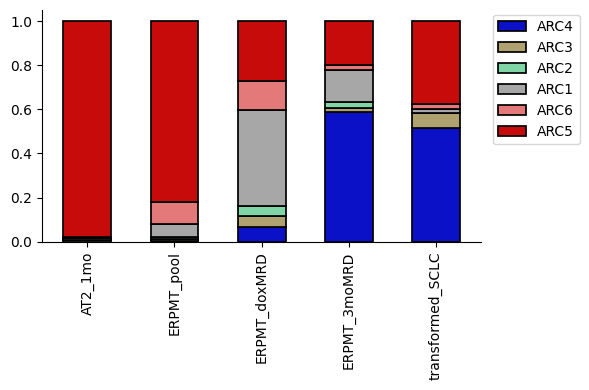

In [207]:
tmp = arc_sample_frac_df.pivot('Sample', columns='Arc')

tmp.index.name = None
tmp.columns.name = None

tmp.columns = tmp.columns.droplevel()

tmp = tmp.loc[['AT2_1mo', 'ERPMT_pool', 'ERPMT_doxMRD', 'ERPMT_3moMRD', 'transformed_SCLC'],:]

matplotlib.style.use('default')

fig, ax = plt.subplots(figsize=(6,4))

sns.despine()

tmp[['ARC4', 'ARC3', 'ARC2', 'ARC1', 'ARC6', 'ARC5']].plot.bar(stacked=True, ax=ax, 
                                                       color=[archetype_n6_cmap[x] for x in ['ARC4', 'ARC3', 'ARC2', 'ARC1', 'ARC6', 'ARC5']],
                                                       edgecolor='black',
                                                       linewidth=1.25,
                                                       width=0.55)

ax.legend(bbox_to_anchor=(1.01, 1.01))

fn = f'{output_dir}/Nearest_Archetype_by_Sample_Barplot.png'
plt.tight_layout()

print(fn)
plt.savefig(fn, dpi=400)

/workdir/varmus_single_cell/merged_pipeline_out/Lineage_Prob_Visuals_pubShare//Nearest_Archetype_by_Sample_Barplot_normalized.png


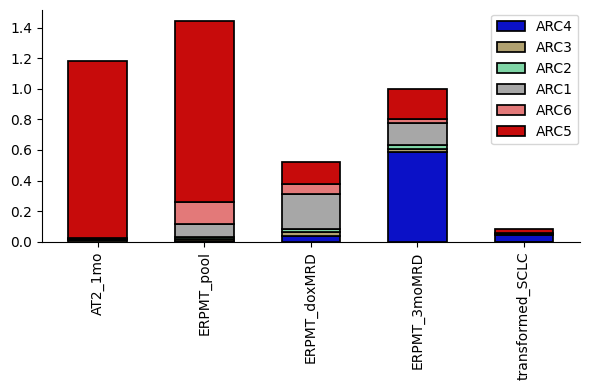

In [208]:
tmp = arc_sample_frac_norm_df.pivot('Sample', columns='Arc')

tmp.index.name = None
tmp.columns.name = None

tmp.columns = tmp.columns.droplevel()

tmp = tmp.loc[['AT2_1mo', 'ERPMT_pool', 'ERPMT_doxMRD', 'ERPMT_3moMRD', 'transformed_SCLC'],:]

matplotlib.style.use('default')

fig, ax = plt.subplots(figsize=(6,4))

sns.despine()

tmp[['ARC4', 'ARC3', 'ARC2', 'ARC1', 'ARC6', 'ARC5']].plot.bar(stacked=True, ax=ax, 
                                                       color=[archetype_n6_cmap[x] for x in ['ARC4', 'ARC3', 'ARC2', 'ARC1', 'ARC6', 'ARC5']],
                                                       edgecolor='black',
                                                       linewidth=1.25,
                                                       width=0.55)

ax.legend(bbox_to_anchor=(1.01, 1.01))

fn = f'{output_dir}/Nearest_Archetype_by_Sample_Barplot_normalized.png'
plt.tight_layout()

print(fn)
plt.savefig(fn, dpi=400)

/workdir/varmus_single_cell/merged_pipeline_out/Lineage_Prob_Visuals_pubShare//Nearest_Archetype_by_Sample_Barplot_log_normalized.png


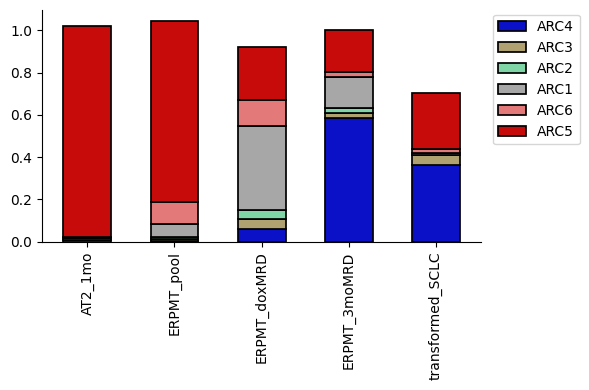

In [209]:
tmp = arc_sample_frac_log_norm_df.pivot('Sample', columns='Arc')

tmp.index.name = None
tmp.columns.name = None

tmp.columns = tmp.columns.droplevel()

tmp = tmp.loc[['AT2_1mo', 'ERPMT_pool', 'ERPMT_doxMRD', 'ERPMT_3moMRD', 'transformed_SCLC'],:]

matplotlib.style.use('default')

fig, ax = plt.subplots(figsize=(6,4))

sns.despine()

tmp[['ARC4', 'ARC3', 'ARC2', 'ARC1', 'ARC6', 'ARC5']].plot.bar(stacked=True, ax=ax, 
                                                       color=[archetype_n6_cmap[x] for x in ['ARC4', 'ARC3', 'ARC2', 'ARC1', 'ARC6', 'ARC5']],
                                                       edgecolor='black',
                                                       linewidth=1.25,
                                                       width=0.55)

ax.legend(bbox_to_anchor=(1.01, 1.01))

fn = f'{output_dir}/Nearest_Archetype_by_Sample_Barplot_log_normalized.png'

plt.tight_layout()

print(fn)
plt.savefig(fn, dpi=400)